# 新洋教育Kaggle零基础教学计划 - 数据挖掘项目
# 预测建筑物的能源消耗

ASHRAE（American Society of Heating, Refrigerating and Air-Conditioning Engineers），中文名称“美国采暖、制冷与空调工程师学会”，于1894年在美国纽约成立，是由暖通空调（HVAC）工程师所组成的学会，全球拥有超过54,000名成员。协会及其成员专注于建筑系统、能源效率、室内空气质量、制冷和行业内的可持续性。通过调研、标准编写、出版和继续教育，ASHRAE发展至现在的规模。

![image](https://www.shell.com/energy-and-innovation/the-energy-future/shell-energy-transition-report/_jcr_content/par/pageHeader/image.img.960.jpeg/1523515186785/cityscape-river-sunshine-hong-kong-china.jpeg?imformat=chrome&imwidth=1280)

问：夏天给大楼降温需要多少钱？

答：非常多！政府正在进行投资，以降低能源成本，减少排放。但是问题是，这些改进是否真的有效？

在这次竞赛中，我们通过**预测冷水表、电表、热水表和蒸汽表的读数**来对这些节能投资进行更好的估计。数据来自近三年来1000栋建筑中的各表读数。大型投资者和金融机构将更倾向于在这一领域投资，以提高建筑能源使用效率。

>**提示：**Code 和 Markdown 区域可通过 **Shift + Enter** 快捷键运行。此外，Markdown可以通过双击进入编辑模式。

我们将这个notebook分为不同的步骤，你可以使用下面的链接来浏览此notebook。

* [Step 1](#step1): 导入数据
* [Step 2](#step2): 探索性数据分析
* [Step 3](#step3): 数据预处理
* [Step 4](#step4): LightGBM
* [Step 5](#step5): 结果预测

在该项目中包含了如下的问题：

* [问题 1](#question1): 回顾课上内容并查阅资料，归纳总结数据预处理需要的步骤。
* [问题 2](#question2): 思考此处为何要进行对数转换。
* [问题 3](#question3): 查阅资料，总结LightGBM与CatBoost的差异。

In [1]:
#导入必要的库
import pandas as pd
import numpy as np
import os
import gc
import copy
import warnings

import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import StratifiedKFold, KFold
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.externals import joblib

warnings.filterwarnings('ignore')
pd.set_option("max_columns", 500)
%matplotlib inline

/opt/conda/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


<a id='step1'></a>
# 1. 导入数据

ASHRAE给出的数据包含大量的特征数据，包括仪表读数，天气和建筑的数据等等。该问题为典型的监督学习问题。比赛举办方提供了6个csv文件，包括5个数据集与1个提交样本。其中数据集的字段含义为：

`[train/test].csv`
- building_id：建筑原数据的外键
- meter : 仪表的id码, {0: 电表 , 1: 冷水表, 2: 蒸汽表, 3: 热水表}，不是每栋建筑都有全部类型的仪表
- timestamp：读表的时间
- meter_reading：目标变量, 用千瓦时（或等效值）表示的能耗。这是带有测量误差的真实数据，其中site0的电表读数出现问题，单位是千英热

`building_meta.csv`
- site_id: 天气文件的外键
- building_id: training.csv对应的外键
- primary_use: 基于EnergyStar property type definitions的建筑物活动的主要类别的指标（education, office…)
- square_feet: 建筑物的总建筑面积
- year_built: 建筑完成的年份
- floor_count: 建筑物层数

`weather_[train/test].csv`：气象站提供的气象数据,尽可能接近现场。
- site_id: 天气文件的外键
- air_temperature: 气温，单位为摄氏度
- cloud_coverage: 天空中被云层覆盖的部分，单位为oktas
- dew_temperature: 露点温度，单位为摄氏度
- precip_depth_1_hr: 降水深度，单位为毫米
- sea_level_pressure: 海平面压力，单位为毫巴/公顷
- wind_direction: 风向，使用的是指南针方向（0-360）
- wind_speed: 风速，单位为米每秒

In [2]:
train = pd.read_csv("../input/ashrae-energy-prediction/train.csv", parse_dates=["timestamp"])
test = pd.read_csv("../input/ashrae-energy-prediction/test.csv", parse_dates=["timestamp"])
building = pd.read_csv('../input/ashrae-energy-prediction/building_metadata.csv')
weather_train = pd.read_csv('../input/ashrae-energy-prediction/weather_train.csv', parse_dates=["timestamp"])
weather_test = pd.read_csv("../input/ashrae-energy-prediction/weather_test.csv", parse_dates=["timestamp"])

In [3]:
train.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01,0.0
1,1,0,2016-01-01,0.0
2,2,0,2016-01-01,0.0
3,3,0,2016-01-01,0.0
4,4,0,2016-01-01,0.0


In [4]:
building.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [5]:
weather_train.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


<a id='step2'></a>
# 2. 探索性数据分析

- 根据主办方提供的数据，"meter"代表仪表的类型，对应关系为 {0: 电表 , 1: 冷水表, 2: 蒸汽表, 3: 热水表}
- 观察各个建筑的仪表读数，可以发现，其中一些建筑的读数在某些区间出现了持续为0的异常情况,也有读数异常的高的值
- 可以通过修改`site`,`meter_type`,`primary_use`三个参数选择想要绘制的数据

关联train表格和building表格用于作图

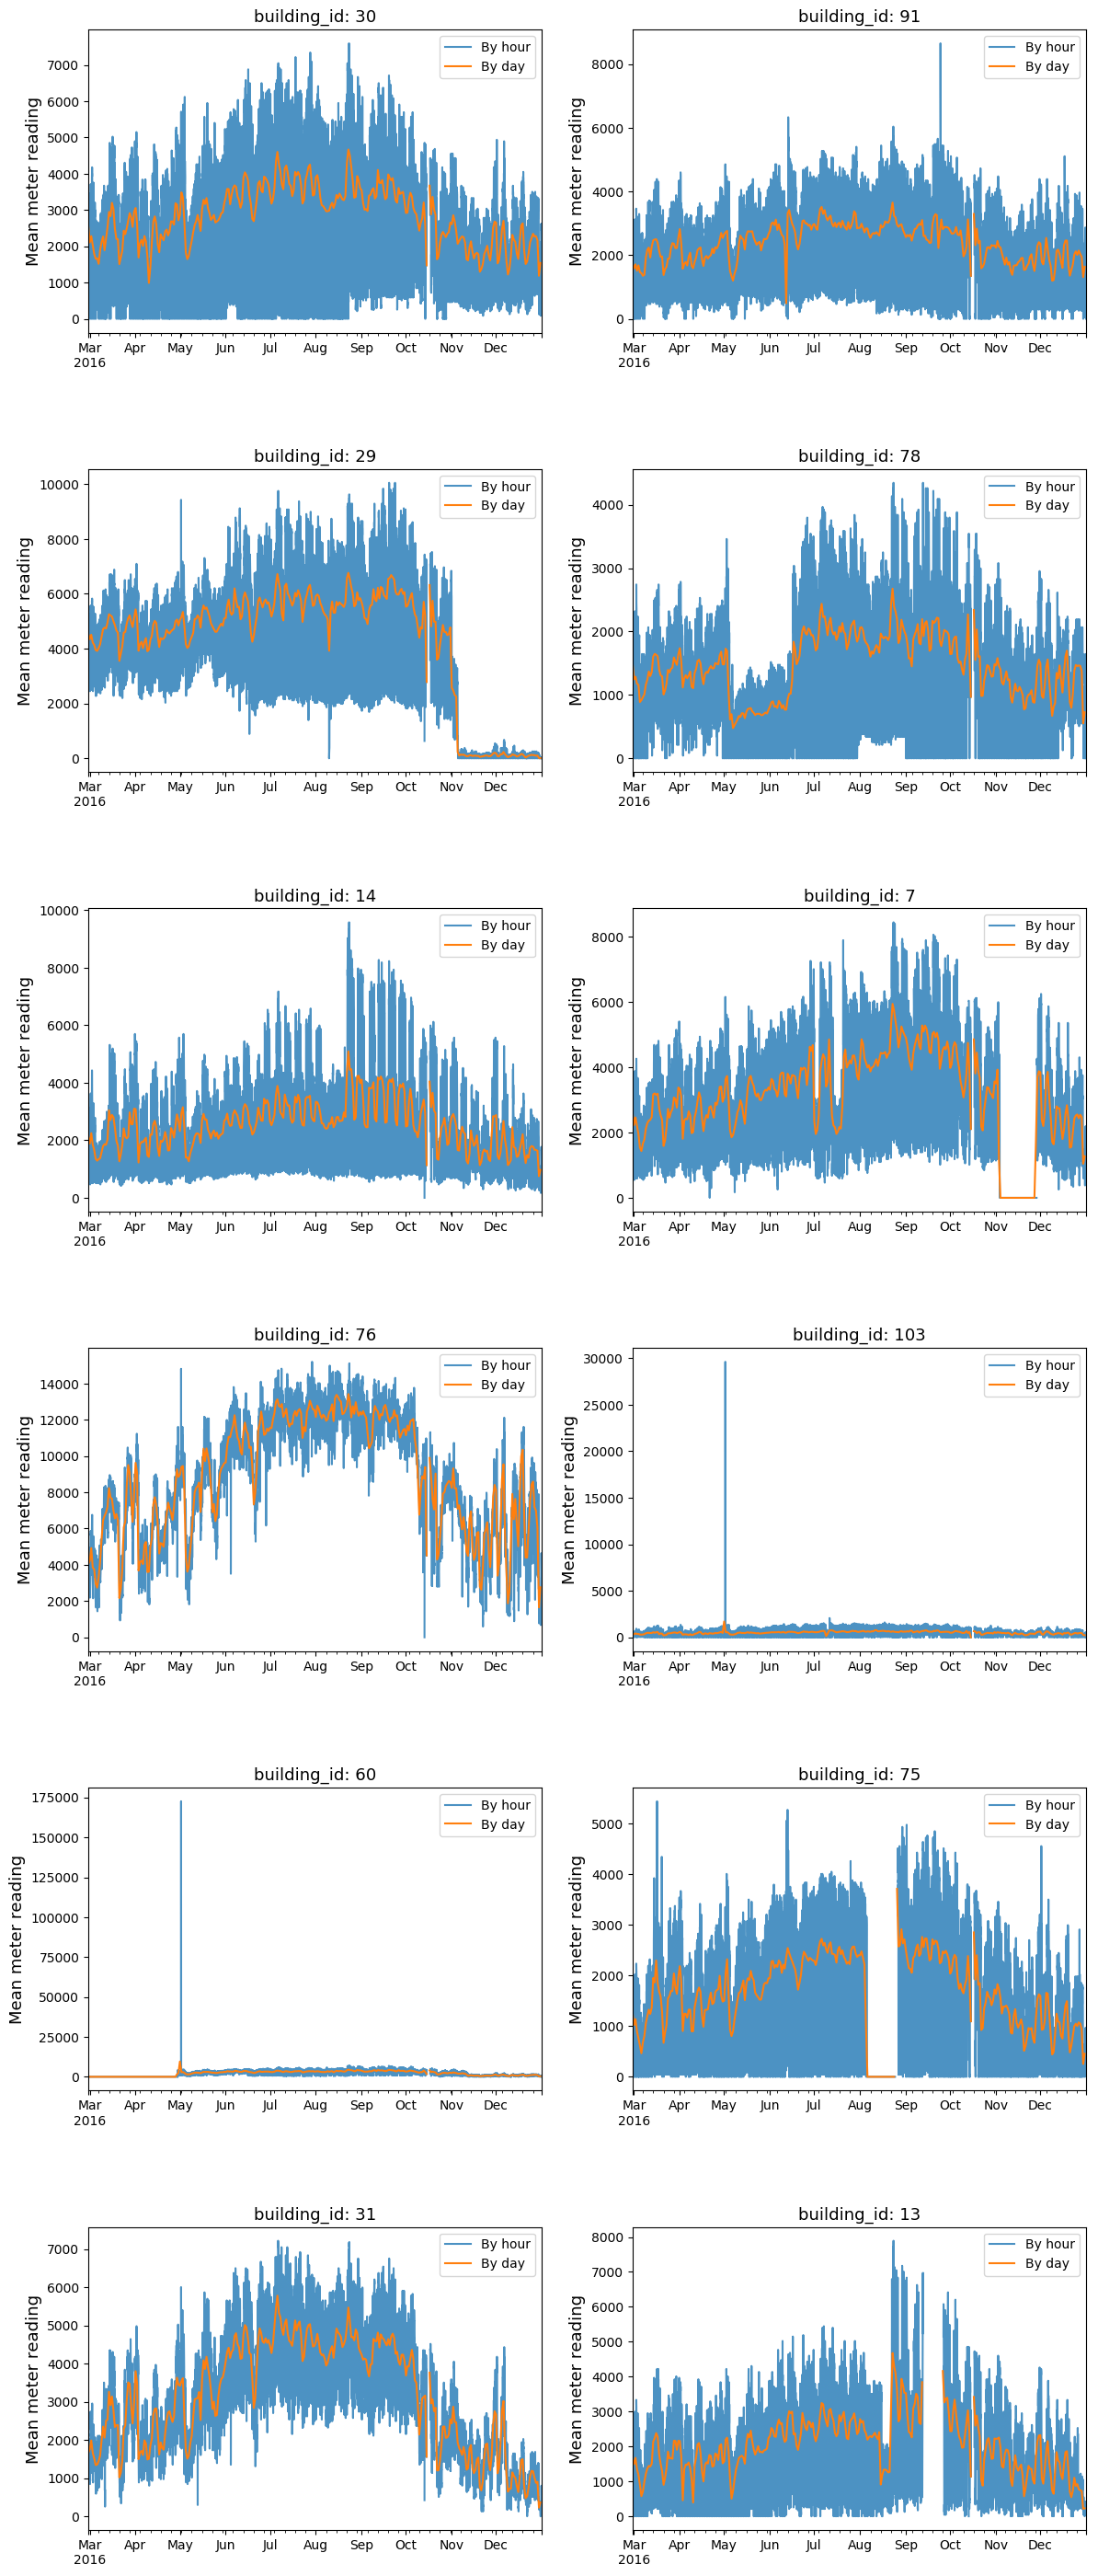

In [6]:
train_plot = train.merge(building, on='building_id', how='left')

site = 0 #建筑物的地点
meter_type = 1 #仪表的类型
primary_use = 'Education' #建筑物的用途

r = int(np.ceil(len(train_plot[(train_plot['site_id'] == site) & (train_plot['primary_use'] == primary_use) & (train_plot['meter'] == meter_type)]['building_id'].value_counts(dropna=False).index.to_list())/2))
fig, axes = plt.subplots(r,2,figsize=(14, 36), dpi=100)
for i, building_id in enumerate(train_plot[(train_plot['site_id'] == site) & (train_plot['primary_use'] == primary_use) & (train_plot['meter'] == meter_type)]['building_id'].value_counts(dropna=False).index.to_list()):
    train_plot[(train_plot['site_id'] == site) & (train_plot['primary_use'] == primary_use) & (train_plot['meter'] == meter_type) & 
               (train_plot['building_id'] == building_id )][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[i%r][i//r], 
               alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13);
    train_plot[(train_plot['site_id'] == site) & (train_plot['primary_use'] == primary_use) & (train_plot['meter'] == meter_type) & 
               (train_plot['building_id'] == building_id )][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes[i%r][i//r], 
               alpha=1, label='By day', color='tab:orange').set_xlabel('');
    axes[i%r][i//r].legend();
    axes[i%r][i//r].set_title('building_id: ' + str(building_id ), fontsize=13);
    plt.subplots_adjust(hspace=0.45)
    
del train_plot,fig,axes,r
gc.collect();

<a id='step3'></a>
# 3. 数据预处理

<a id='question1'></a>
### __问题 1:__

回顾课上内容并查阅资料，归纳总结数据预处理需要的步骤。

__回答:__ 

## 3.1 数据类型转换

In [7]:
def compress_dataframe(df):
    '''将所有数据的类型都转换为数值型'''
    result = df.copy()
    for col in result.columns:
        col_data = result[col]
        dn = col_data.dtype.name
        if dn == "object":
            result[col] = pd.to_numeric(col_data.astype("category").cat.codes, downcast="integer")
        elif dn == "bool":
            result[col] = col_data.astype("int8")
        elif dn.startswith("int") or (col_data.round() == col_data).all():
            result[col] = pd.to_numeric(col_data, downcast="integer")
        else:
            result[col] = pd.to_numeric(col_data, downcast='float')
    return result

## 3.2 缺失值填充与特征扩展

In [8]:
def set_time(df):
    df.timestamp = (df.timestamp - pd.to_datetime("2016-01-01")).dt.total_seconds() // 3600
    #这里将timestamp转换成了16年1月1日0点开始计算的小时数‘//’代表除法运算后取整
    return df

# 根据分析得出各个site来自哪个时区，来修正时间
# https://www.kaggle.com/patrick0302/locate-cities-according-weather-temperature
site_GMT_offsets = [-5, 0, -7, -5, -8, 0, -5, -5, -5, -6, -7, -5, 0, -6, -5, -5]

#转换天气数据表格中的时间,并填充缺失值
def weather_set_time(df,time_zone):
    df.timestamp = (df.timestamp - pd.to_datetime("2016-01-01")).dt.total_seconds() // 3600
    
    GMT_offset_map = {site: offset for site, offset in enumerate(site_GMT_offsets)}
    df.timestamp = df.timestamp + df.site_id.map(GMT_offset_map)
    #根据时区的不同，统一时间
    site_dfs = []
    for site_id in df.site_id.unique():
        # 确保包括所有可能的小时数
        site_df = df[df.site_id == site_id].set_index("timestamp").reindex(time_zone)
        site_df.site_id = site_id
        for col in [c for c in site_df.columns if c != "site_id"]:
            site_df[f"had_{col}"] = ~site_df[col].isna()
            site_df[col] = site_df[col].interpolate(limit_direction='both', method='linear')
            # 这里使用中位数来填充缺失值
            site_df[col] = site_df[col].fillna(df[col].median())
        site_dfs.append(site_df)
    df = pd.concat(site_dfs).reset_index()  # make timestamp back into a regular column
    for col in df.columns:
        if df[col].isna().any(): df[f"had_{col}"] = ~df[col].isna()
    #如果某列其中有缺失值，就增加一列新的特征：had_xxx 表示这一行在xxx这一列是否有记录
    return df
    
#增加星期，月份，时间的特征
def _add_time_features(X):
    return X.assign(tm_day_of_week=((X.timestamp // 24) % 7), tm_hour_of_day=(X.timestamp % 24))

building = compress_dataframe(building.fillna(-1)).set_index("building_id")

train = compress_dataframe(set_time(train))
test = compress_dataframe(set_time(test)).set_index("row_id")
weather_train = compress_dataframe(weather_set_time(weather_train,range(8784))).set_index(["site_id", "timestamp"])
weather_test = compress_dataframe(weather_set_time(weather_test,range(8784,26304))).set_index(["site_id", "timestamp"])

## 3.3 关联数据

In [9]:
def combined_data(df,weather):
    df = compress_dataframe(df.join(building, on="building_id").join(weather,
        on=["site_id", "timestamp"]).fillna(-1))
    return df.drop(columns=["meter_reading"]),df.meter_reading

## 3.4 异常值处理 

In [10]:
def make_is_bad_zero(Xy_subset, min_interval=48, summer_start=3000, summer_end=7500):
    #夏天，3000/24=125，7500/24=312.5,第125天到第312.5天为夏天。

    meter = Xy_subset.meter_id.iloc[0]
    is_zero = Xy_subset.meter_reading == 0 #返回读数为0的电表的indices
    if meter == 0:
        #电表的度数不应该为0，所以电表（meter为0）读数为0的行从training dataframe中drop掉
        return is_zero

    transitions = (is_zero != is_zero.shift(1))#出现0和非0变化的位置
    all_sequence_ids = transitions.cumsum()#到各位置出现的变化的和，是一个pd.Seires
    ids = all_sequence_ids[is_zero].rename("ids")#将其中读数为0的提取出来
    if meter in [2, 3]:
        # 蒸汽和热水有可能在夏天被关闭
        keep = set(ids[(Xy_subset.timestamp < summer_start) |
                       (Xy_subset.timestamp > summer_end)].unique())#不在夏天的indices
        is_bad = ids.isin(keep) & (ids.map(ids.value_counts()) >= min_interval) 
        #将不在夏天却被关闭的蒸汽和热水表提取出来，至少被关闭了48小时以上的
    elif meter == 1:
        time_ids = ids.to_frame().join(Xy_subset.timestamp).set_index("timestamp").ids#将ids和timestamp对应起来
        is_bad = ids.map(ids.value_counts()) >= min_interval#关闭时间大于48小时的

        # 冷水在冬天可能被关闭
        jan_id = time_ids.get(0, False)#一月份的开始的id
        dec_id = time_ids.get(8283, False)#十二月份开始的id
        if (jan_id and dec_id and jan_id == time_ids.get(500, False) and
                dec_id == time_ids.get(8783, False)):
        #如果一月500小时和十二月500小时的读表都为0的话
            is_bad = is_bad & (~(ids.isin(set([jan_id, dec_id]))))
            #将这一部分的的行从is_bad中删除
    else:
        raise Exception(f"Unexpected meter type: {meter}")

    result = is_zero.copy()
    result.update(is_bad)
    return result

def find_bad_zeros(X, y):
    """返回仅包含应该删除的行的Index"""
    Xy = X.assign(meter_reading=y, meter_id=X.meter)
    is_bad_zero = Xy.groupby(["building_id", "meter"]).apply(make_is_bad_zero)
    return is_bad_zero[is_bad_zero].index.droplevel([0, 1])

def find_bad_sitezero(X):
    """返回Site 0 读数异常的行的index."""
    return X[(X.timestamp < 3378) & (X.site_id == 0) & (X.meter == 0)].index

def find_bad_building1099(X, y):
    """返回建筑1099的读数异常高的行的index ."""
    return X[(X.building_id == 1099) & (X.meter == 2) & (y > 3e4)].index

def find_bad_rows(X, y):
    return find_bad_zeros(X, y).union(find_bad_sitezero(X)).union(find_bad_building1099(X, y))

In [11]:
X, y = combined_data(train,weather_train)

bad_rows = find_bad_rows(X, y)
#输出异常值的index
pd.Series(bad_rows.sort_values()).to_csv("rows_to_drop.csv", header=False, index=False)

X = X.drop(index=bad_rows)
y = y.reindex_like(X)

X = _add_time_features(X)
X = compress_dataframe(X)
X = X.drop(columns="timestamp")  # drop掉原本的timestamp

del bad_rows,train,weather_train
gc.collect();

## 3.5 评价函数

由于需要预测连续值，因此需要采用回归模型。由于该项目是Kaggle赛题，测试集是使用均方根对数误差 RMSLE（Root Mean Squared Logarithmic Error, RMSLE)评测的，因此这里只能使用RMSLE。RMSLE的计算公式为：

$${\rm RMSLE} = \sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 }$$

其中
- $n$（public/private）数据集中的样本总数,
- $p_i$ 是目标的预测值
- $a_i$ 第i个目标的真实值.
- $\log(x)$ 是自然对数

我们只需要对目标值进行$y = \log(y+1)$的变换，就可以使用常见的RMSE作为评价函数，我们使用numpy中的log1p就可以实现。

注意：进行预测的时候需要使用$y = e^y-1$将目标值转换回去，可以使用 y = np.exp1m(y)。

In [12]:
#对目标值进行变换
y = np.log1p(y)

<a id='question2'></a>
### __问题 2:__

思考此处为何要进行对数转换。

__回答:__ 

<a id='step4'></a>
# 4. LightGBM
## 4.1 模型参数
LightGBM 主要调节的参数包括：
- `learning_rate`：迭代步长,学习率；
- `num_leaves`：LightGBM使用leaf-wise的算法，在调节树的复杂度时，使用num_leaves，较小导致欠拟合，较大导致过拟合；
- `subsample`：0-1之间，控制每棵树随机采样的比例，减小这个参数的值，算法会更加保守，避免过拟合。但如果这个值设置得过小，可能会导致欠拟合；
- `lambda_l2`：L2正则化系数，用来控制过拟合；
- `num_trees`：迭代步数。

In [13]:
params = {
          'boosting_type':'gbdt', 
          'num_leaves':40, 
          #'max_depth':- 1, 
          'learning_rate':0.03, 
          'n_estimators':1000, 
          #'subsample_for_bin':200000, 
          'objective':'regression', 
          #'class_weight':None, 
          #'min_split_gain':0.0, 
          #'min_child_weight':0.001, 
          #'min_child_samples':20, 
          'subsample':0.8, 
          #'subsample_freq':0, 
          #'colsample_bytree':1.0, 
          #'reg_alpha':0.0, 
          'reg_lambda':3, 
          #'random_state':None, 
          #'n_jobs':- 1, 
          #'silent':True, 
          #'importance_type':'split'
         }

In [14]:
#params = {
 #   'task': 'train',
  #  'boosting_type': 'gbdt',  
   # 'objective': 'regression',  
    #'metric': 'rmse',  
    #'num_leaves': 40,  
    #'subsample':0.8,
    #'learning_rate': 0.03,  
    #'verbose': 1,
    #'lambda_l2':3
#}

#num_trees = 1000

#设置分类变量
categorical_features=['building_id', 'site_id', 'primary_use', 'had_air_temperature', 'had_cloud_coverage', 
                      'had_dew_temperature', 'had_precip_depth_1_hr','had_sea_level_pressure', 'had_wind_direction',
                      'had_wind_speed', 'tm_day_of_week', 'tm_hour_of_day']

## 4.2 模型训练

In [15]:
n_splits = 3

for val in X['meter'].unique():
    X1 = X[X['meter'] == val].drop(columns=['meter'])
    kf = StratifiedKFold(n_splits=n_splits,random_state=42)
    #使用StratifiedKFold，让指定列在每一个fold中的分布相同，这里设置分为3个fold
    t = 0
    for train_index, test_index in kf.split(X1, X1['tm_hour_of_day']):
        #让每个fold中['tm_hour_of_day']的分布相同
        train_features = X1.iloc[train_index]
        train_target = y[X1.iloc[train_index].index]
        
        test_features = X1.iloc[test_index]
        test_target = y[X1.iloc[test_index].index]
        #print(test_features.head())
        #print(test_target.head())
        
        d_train = lgb.Dataset(train_features, train_target, categorical_feature=categorical_features)
        d_eval = lgb.Dataset(test_features,test_target, categorical_feature=categorical_features)
        print("Building model meter :",val,'fold:',t)        
        
        #md = lgb.train(params, d_train, num_boost_round=num_trees, valid_sets=(d_train, d_eval), 
        #              early_stopping_rounds=200,verbose_eval=20)
        md = LGBMRegressor(**params)
        md.fit(train_features, train_target, eval_set=[(test_features, test_target)], eval_metric='rmse', early_stopping_rounds=200, verbose=True)
        joblib.dump(md, 'lgb_val{}_fold{}.bin'.format(val,t))
        #md.save_model('lgb_val{}_fold{}.bin'.format(val,t))
        t += 1
    del X1  
        
del d_train, d_eval, train_features, test_features, md
gc.collect();

Building model meter : 0 fold: 0
[1]	valid_0's rmse: 1.46731	valid_0's l2: 2.153
Training until validation scores don't improve for 200 rounds
[2]	valid_0's rmse: 1.43757	valid_0's l2: 2.06661
[3]	valid_0's rmse: 1.40911	valid_0's l2: 1.98558
[4]	valid_0's rmse: 1.38149	valid_0's l2: 1.90852
[5]	valid_0's rmse: 1.35521	valid_0's l2: 1.8366
[6]	valid_0's rmse: 1.32961	valid_0's l2: 1.76786
[7]	valid_0's rmse: 1.30538	valid_0's l2: 1.70401
[8]	valid_0's rmse: 1.28222	valid_0's l2: 1.64408
[9]	valid_0's rmse: 1.25928	valid_0's l2: 1.58578
[10]	valid_0's rmse: 1.23788	valid_0's l2: 1.53235
[11]	valid_0's rmse: 1.21624	valid_0's l2: 1.47924
[12]	valid_0's rmse: 1.19589	valid_0's l2: 1.43015
[13]	valid_0's rmse: 1.1759	valid_0's l2: 1.38274
[14]	valid_0's rmse: 1.15674	valid_0's l2: 1.33805
[15]	valid_0's rmse: 1.13863	valid_0's l2: 1.29648
[16]	valid_0's rmse: 1.12112	valid_0's l2: 1.25691
[17]	valid_0's rmse: 1.1046	valid_0's l2: 1.22013
[18]	valid_0's rmse: 1.08829	valid_0's l2: 1.18437
[

[155]	valid_0's rmse: 0.638541	valid_0's l2: 0.407734
[156]	valid_0's rmse: 0.637873	valid_0's l2: 0.406882
[157]	valid_0's rmse: 0.637335	valid_0's l2: 0.406195
[158]	valid_0's rmse: 0.636612	valid_0's l2: 0.405275
[159]	valid_0's rmse: 0.635979	valid_0's l2: 0.404469
[160]	valid_0's rmse: 0.635431	valid_0's l2: 0.403772
[161]	valid_0's rmse: 0.634941	valid_0's l2: 0.40315
[162]	valid_0's rmse: 0.634223	valid_0's l2: 0.402239
[163]	valid_0's rmse: 0.633476	valid_0's l2: 0.401292
[164]	valid_0's rmse: 0.632462	valid_0's l2: 0.400008
[165]	valid_0's rmse: 0.632028	valid_0's l2: 0.399459
[166]	valid_0's rmse: 0.631491	valid_0's l2: 0.398781
[167]	valid_0's rmse: 0.63093	valid_0's l2: 0.398073
[168]	valid_0's rmse: 0.630332	valid_0's l2: 0.397319
[169]	valid_0's rmse: 0.629557	valid_0's l2: 0.396342
[170]	valid_0's rmse: 0.628665	valid_0's l2: 0.39522
[171]	valid_0's rmse: 0.628142	valid_0's l2: 0.394562
[172]	valid_0's rmse: 0.627474	valid_0's l2: 0.393723
[173]	valid_0's rmse: 0.627022	

[308]	valid_0's rmse: 0.57368	valid_0's l2: 0.329109
[309]	valid_0's rmse: 0.573364	valid_0's l2: 0.328747
[310]	valid_0's rmse: 0.573119	valid_0's l2: 0.328465
[311]	valid_0's rmse: 0.572895	valid_0's l2: 0.328209
[312]	valid_0's rmse: 0.572729	valid_0's l2: 0.328018
[313]	valid_0's rmse: 0.572711	valid_0's l2: 0.327998
[314]	valid_0's rmse: 0.57235	valid_0's l2: 0.327584
[315]	valid_0's rmse: 0.572342	valid_0's l2: 0.327576
[316]	valid_0's rmse: 0.572266	valid_0's l2: 0.327488
[317]	valid_0's rmse: 0.572051	valid_0's l2: 0.327243
[318]	valid_0's rmse: 0.572068	valid_0's l2: 0.327262
[319]	valid_0's rmse: 0.571864	valid_0's l2: 0.327029
[320]	valid_0's rmse: 0.571869	valid_0's l2: 0.327034
[321]	valid_0's rmse: 0.571682	valid_0's l2: 0.32682
[322]	valid_0's rmse: 0.571385	valid_0's l2: 0.326481
[323]	valid_0's rmse: 0.57104	valid_0's l2: 0.326087
[324]	valid_0's rmse: 0.571032	valid_0's l2: 0.326078
[325]	valid_0's rmse: 0.571052	valid_0's l2: 0.3261
[326]	valid_0's rmse: 0.570829	val

[461]	valid_0's rmse: 0.542741	valid_0's l2: 0.294568
[462]	valid_0's rmse: 0.542668	valid_0's l2: 0.294488
[463]	valid_0's rmse: 0.542448	valid_0's l2: 0.29425
[464]	valid_0's rmse: 0.541986	valid_0's l2: 0.293748
[465]	valid_0's rmse: 0.541693	valid_0's l2: 0.293431
[466]	valid_0's rmse: 0.541762	valid_0's l2: 0.293506
[467]	valid_0's rmse: 0.541753	valid_0's l2: 0.293496
[468]	valid_0's rmse: 0.541457	valid_0's l2: 0.293176
[469]	valid_0's rmse: 0.541281	valid_0's l2: 0.292985
[470]	valid_0's rmse: 0.541153	valid_0's l2: 0.292846
[471]	valid_0's rmse: 0.540967	valid_0's l2: 0.292645
[472]	valid_0's rmse: 0.540969	valid_0's l2: 0.292648
[473]	valid_0's rmse: 0.540979	valid_0's l2: 0.292658
[474]	valid_0's rmse: 0.540841	valid_0's l2: 0.292509
[475]	valid_0's rmse: 0.540481	valid_0's l2: 0.29212
[476]	valid_0's rmse: 0.540416	valid_0's l2: 0.292049
[477]	valid_0's rmse: 0.540418	valid_0's l2: 0.292052
[478]	valid_0's rmse: 0.540423	valid_0's l2: 0.292057
[479]	valid_0's rmse: 0.540142

[614]	valid_0's rmse: 0.518241	valid_0's l2: 0.268574
[615]	valid_0's rmse: 0.518183	valid_0's l2: 0.268513
[616]	valid_0's rmse: 0.518098	valid_0's l2: 0.268426
[617]	valid_0's rmse: 0.517992	valid_0's l2: 0.268315
[618]	valid_0's rmse: 0.517948	valid_0's l2: 0.26827
[619]	valid_0's rmse: 0.517773	valid_0's l2: 0.268088
[620]	valid_0's rmse: 0.51774	valid_0's l2: 0.268054
[621]	valid_0's rmse: 0.517681	valid_0's l2: 0.267994
[622]	valid_0's rmse: 0.517568	valid_0's l2: 0.267876
[623]	valid_0's rmse: 0.517524	valid_0's l2: 0.267831
[624]	valid_0's rmse: 0.51748	valid_0's l2: 0.267786
[625]	valid_0's rmse: 0.517376	valid_0's l2: 0.267678
[626]	valid_0's rmse: 0.517188	valid_0's l2: 0.267484
[627]	valid_0's rmse: 0.517069	valid_0's l2: 0.267361
[628]	valid_0's rmse: 0.516599	valid_0's l2: 0.266874
[629]	valid_0's rmse: 0.516633	valid_0's l2: 0.266909
[630]	valid_0's rmse: 0.516476	valid_0's l2: 0.266748
[631]	valid_0's rmse: 0.516425	valid_0's l2: 0.266694
[632]	valid_0's rmse: 0.516302	

[767]	valid_0's rmse: 0.49911	valid_0's l2: 0.249111
[768]	valid_0's rmse: 0.498691	valid_0's l2: 0.248692
[769]	valid_0's rmse: 0.498627	valid_0's l2: 0.248629
[770]	valid_0's rmse: 0.498556	valid_0's l2: 0.248558
[771]	valid_0's rmse: 0.498274	valid_0's l2: 0.248277
[772]	valid_0's rmse: 0.498189	valid_0's l2: 0.248192
[773]	valid_0's rmse: 0.49819	valid_0's l2: 0.248193
[774]	valid_0's rmse: 0.498262	valid_0's l2: 0.248265
[775]	valid_0's rmse: 0.498173	valid_0's l2: 0.248177
[776]	valid_0's rmse: 0.497949	valid_0's l2: 0.247953
[777]	valid_0's rmse: 0.497725	valid_0's l2: 0.24773
[778]	valid_0's rmse: 0.497566	valid_0's l2: 0.247572
[779]	valid_0's rmse: 0.497523	valid_0's l2: 0.247529
[780]	valid_0's rmse: 0.497344	valid_0's l2: 0.247351
[781]	valid_0's rmse: 0.497299	valid_0's l2: 0.247306
[782]	valid_0's rmse: 0.497238	valid_0's l2: 0.247245
[783]	valid_0's rmse: 0.497161	valid_0's l2: 0.247169
[784]	valid_0's rmse: 0.496926	valid_0's l2: 0.246936
[785]	valid_0's rmse: 0.496638	

[920]	valid_0's rmse: 0.482414	valid_0's l2: 0.232723
[921]	valid_0's rmse: 0.482284	valid_0's l2: 0.232598
[922]	valid_0's rmse: 0.482092	valid_0's l2: 0.232413
[923]	valid_0's rmse: 0.482072	valid_0's l2: 0.232393
[924]	valid_0's rmse: 0.482022	valid_0's l2: 0.232345
[925]	valid_0's rmse: 0.481959	valid_0's l2: 0.232285
[926]	valid_0's rmse: 0.481923	valid_0's l2: 0.23225
[927]	valid_0's rmse: 0.481896	valid_0's l2: 0.232224
[928]	valid_0's rmse: 0.48185	valid_0's l2: 0.23218
[929]	valid_0's rmse: 0.481825	valid_0's l2: 0.232155
[930]	valid_0's rmse: 0.481787	valid_0's l2: 0.232119
[931]	valid_0's rmse: 0.481714	valid_0's l2: 0.232048
[932]	valid_0's rmse: 0.481685	valid_0's l2: 0.23202
[933]	valid_0's rmse: 0.481582	valid_0's l2: 0.231921
[934]	valid_0's rmse: 0.481528	valid_0's l2: 0.231869
[935]	valid_0's rmse: 0.481479	valid_0's l2: 0.231822
[936]	valid_0's rmse: 0.48148	valid_0's l2: 0.231823
[937]	valid_0's rmse: 0.481408	valid_0's l2: 0.231754
[938]	valid_0's rmse: 0.48126	val

[72]	valid_0's rmse: 0.769635	valid_0's l2: 0.592337
[73]	valid_0's rmse: 0.767611	valid_0's l2: 0.589227
[74]	valid_0's rmse: 0.76542	valid_0's l2: 0.585868
[75]	valid_0's rmse: 0.763318	valid_0's l2: 0.582655
[76]	valid_0's rmse: 0.761551	valid_0's l2: 0.57996
[77]	valid_0's rmse: 0.759395	valid_0's l2: 0.57668
[78]	valid_0's rmse: 0.75749	valid_0's l2: 0.573792
[79]	valid_0's rmse: 0.755507	valid_0's l2: 0.57079
[80]	valid_0's rmse: 0.753638	valid_0's l2: 0.567971
[81]	valid_0's rmse: 0.751932	valid_0's l2: 0.565402
[82]	valid_0's rmse: 0.750365	valid_0's l2: 0.563047
[83]	valid_0's rmse: 0.748318	valid_0's l2: 0.55998
[84]	valid_0's rmse: 0.746301	valid_0's l2: 0.556966
[85]	valid_0's rmse: 0.744822	valid_0's l2: 0.554759
[86]	valid_0's rmse: 0.743115	valid_0's l2: 0.55222
[87]	valid_0's rmse: 0.741269	valid_0's l2: 0.54948
[88]	valid_0's rmse: 0.738965	valid_0's l2: 0.54607
[89]	valid_0's rmse: 0.7371	valid_0's l2: 0.543317
[90]	valid_0's rmse: 0.735363	valid_0's l2: 0.540759
[91]

[225]	valid_0's rmse: 0.632044	valid_0's l2: 0.399479
[226]	valid_0's rmse: 0.631747	valid_0's l2: 0.399104
[227]	valid_0's rmse: 0.631295	valid_0's l2: 0.398534
[228]	valid_0's rmse: 0.630854	valid_0's l2: 0.397976
[229]	valid_0's rmse: 0.630407	valid_0's l2: 0.397413
[230]	valid_0's rmse: 0.629723	valid_0's l2: 0.396552
[231]	valid_0's rmse: 0.628929	valid_0's l2: 0.395551
[232]	valid_0's rmse: 0.628102	valid_0's l2: 0.394512
[233]	valid_0's rmse: 0.627901	valid_0's l2: 0.394259
[234]	valid_0's rmse: 0.627487	valid_0's l2: 0.39374
[235]	valid_0's rmse: 0.626627	valid_0's l2: 0.392662
[236]	valid_0's rmse: 0.625855	valid_0's l2: 0.391695
[237]	valid_0's rmse: 0.625186	valid_0's l2: 0.390858
[238]	valid_0's rmse: 0.624911	valid_0's l2: 0.390513
[239]	valid_0's rmse: 0.624588	valid_0's l2: 0.39011
[240]	valid_0's rmse: 0.624213	valid_0's l2: 0.389642
[241]	valid_0's rmse: 0.623883	valid_0's l2: 0.38923
[242]	valid_0's rmse: 0.623715	valid_0's l2: 0.389021
[243]	valid_0's rmse: 0.623098	

[378]	valid_0's rmse: 0.570673	valid_0's l2: 0.325668
[379]	valid_0's rmse: 0.570374	valid_0's l2: 0.325326
[380]	valid_0's rmse: 0.569782	valid_0's l2: 0.324651
[381]	valid_0's rmse: 0.569435	valid_0's l2: 0.324256
[382]	valid_0's rmse: 0.569296	valid_0's l2: 0.324098
[383]	valid_0's rmse: 0.569021	valid_0's l2: 0.323785
[384]	valid_0's rmse: 0.568686	valid_0's l2: 0.323404
[385]	valid_0's rmse: 0.568344	valid_0's l2: 0.323015
[386]	valid_0's rmse: 0.56811	valid_0's l2: 0.322749
[387]	valid_0's rmse: 0.567607	valid_0's l2: 0.322177
[388]	valid_0's rmse: 0.567374	valid_0's l2: 0.321913
[389]	valid_0's rmse: 0.566915	valid_0's l2: 0.321393
[390]	valid_0's rmse: 0.566664	valid_0's l2: 0.321109
[391]	valid_0's rmse: 0.566665	valid_0's l2: 0.32111
[392]	valid_0's rmse: 0.5661	valid_0's l2: 0.32047
[393]	valid_0's rmse: 0.565722	valid_0's l2: 0.320041
[394]	valid_0's rmse: 0.565516	valid_0's l2: 0.319808
[395]	valid_0's rmse: 0.565275	valid_0's l2: 0.319536
[396]	valid_0's rmse: 0.565103	va

[531]	valid_0's rmse: 0.529662	valid_0's l2: 0.280542
[532]	valid_0's rmse: 0.529176	valid_0's l2: 0.280027
[533]	valid_0's rmse: 0.529134	valid_0's l2: 0.279983
[534]	valid_0's rmse: 0.528898	valid_0's l2: 0.279733
[535]	valid_0's rmse: 0.528689	valid_0's l2: 0.279512
[536]	valid_0's rmse: 0.528281	valid_0's l2: 0.279081
[537]	valid_0's rmse: 0.52787	valid_0's l2: 0.278647
[538]	valid_0's rmse: 0.527761	valid_0's l2: 0.278532
[539]	valid_0's rmse: 0.527566	valid_0's l2: 0.278326
[540]	valid_0's rmse: 0.527289	valid_0's l2: 0.278034
[541]	valid_0's rmse: 0.526716	valid_0's l2: 0.277429
[542]	valid_0's rmse: 0.526443	valid_0's l2: 0.277142
[543]	valid_0's rmse: 0.526041	valid_0's l2: 0.27672
[544]	valid_0's rmse: 0.525942	valid_0's l2: 0.276615
[545]	valid_0's rmse: 0.525816	valid_0's l2: 0.276483
[546]	valid_0's rmse: 0.525708	valid_0's l2: 0.276369
[547]	valid_0's rmse: 0.525336	valid_0's l2: 0.275978
[548]	valid_0's rmse: 0.525049	valid_0's l2: 0.275677
[549]	valid_0's rmse: 0.525006

[684]	valid_0's rmse: 0.497868	valid_0's l2: 0.247873
[685]	valid_0's rmse: 0.497873	valid_0's l2: 0.247877
[686]	valid_0's rmse: 0.497809	valid_0's l2: 0.247813
[687]	valid_0's rmse: 0.497766	valid_0's l2: 0.247771
[688]	valid_0's rmse: 0.49748	valid_0's l2: 0.247487
[689]	valid_0's rmse: 0.497333	valid_0's l2: 0.24734
[690]	valid_0's rmse: 0.497047	valid_0's l2: 0.247056
[691]	valid_0's rmse: 0.496905	valid_0's l2: 0.246915
[692]	valid_0's rmse: 0.496882	valid_0's l2: 0.246892
[693]	valid_0's rmse: 0.496748	valid_0's l2: 0.246759
[694]	valid_0's rmse: 0.496617	valid_0's l2: 0.246628
[695]	valid_0's rmse: 0.49631	valid_0's l2: 0.246324
[696]	valid_0's rmse: 0.49615	valid_0's l2: 0.246165
[697]	valid_0's rmse: 0.495848	valid_0's l2: 0.245865
[698]	valid_0's rmse: 0.495718	valid_0's l2: 0.245736
[699]	valid_0's rmse: 0.495639	valid_0's l2: 0.245658
[700]	valid_0's rmse: 0.495571	valid_0's l2: 0.245591
[701]	valid_0's rmse: 0.495486	valid_0's l2: 0.245506
[702]	valid_0's rmse: 0.495332	v

[837]	valid_0's rmse: 0.476955	valid_0's l2: 0.227486
[838]	valid_0's rmse: 0.476778	valid_0's l2: 0.227317
[839]	valid_0's rmse: 0.47661	valid_0's l2: 0.227157
[840]	valid_0's rmse: 0.476611	valid_0's l2: 0.227158
[841]	valid_0's rmse: 0.476504	valid_0's l2: 0.227056
[842]	valid_0's rmse: 0.476486	valid_0's l2: 0.227039
[843]	valid_0's rmse: 0.476305	valid_0's l2: 0.226867
[844]	valid_0's rmse: 0.476051	valid_0's l2: 0.226625
[845]	valid_0's rmse: 0.475974	valid_0's l2: 0.226551
[846]	valid_0's rmse: 0.475714	valid_0's l2: 0.226303
[847]	valid_0's rmse: 0.475527	valid_0's l2: 0.226126
[848]	valid_0's rmse: 0.47544	valid_0's l2: 0.226043
[849]	valid_0's rmse: 0.475289	valid_0's l2: 0.2259
[850]	valid_0's rmse: 0.475129	valid_0's l2: 0.225747
[851]	valid_0's rmse: 0.474996	valid_0's l2: 0.225621
[852]	valid_0's rmse: 0.474976	valid_0's l2: 0.225603
[853]	valid_0's rmse: 0.474817	valid_0's l2: 0.225451
[854]	valid_0's rmse: 0.474678	valid_0's l2: 0.225319
[855]	valid_0's rmse: 0.47465	va

[990]	valid_0's rmse: 0.461515	valid_0's l2: 0.212997
[991]	valid_0's rmse: 0.461415	valid_0's l2: 0.212904
[992]	valid_0's rmse: 0.461277	valid_0's l2: 0.212777
[993]	valid_0's rmse: 0.461176	valid_0's l2: 0.212683
[994]	valid_0's rmse: 0.461097	valid_0's l2: 0.212611
[995]	valid_0's rmse: 0.461073	valid_0's l2: 0.212588
[996]	valid_0's rmse: 0.460973	valid_0's l2: 0.212496
[997]	valid_0's rmse: 0.460973	valid_0's l2: 0.212496
[998]	valid_0's rmse: 0.460898	valid_0's l2: 0.212427
[999]	valid_0's rmse: 0.460878	valid_0's l2: 0.212409
[1000]	valid_0's rmse: 0.460804	valid_0's l2: 0.21234
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.460804	valid_0's l2: 0.21234
Building model meter : 0 fold: 2
[1]	valid_0's rmse: 1.48798	valid_0's l2: 2.21408
Training until validation scores don't improve for 200 rounds
[2]	valid_0's rmse: 1.458	valid_0's l2: 2.12575
[3]	valid_0's rmse: 1.42937	valid_0's l2: 2.04309
[4]	valid_0's rmse: 1.40169	valid_0's l2: 1.96473
[5]	valid_0

[142]	valid_0's rmse: 0.668009	valid_0's l2: 0.446236
[143]	valid_0's rmse: 0.667415	valid_0's l2: 0.445443
[144]	valid_0's rmse: 0.666507	valid_0's l2: 0.444232
[145]	valid_0's rmse: 0.665989	valid_0's l2: 0.443542
[146]	valid_0's rmse: 0.66544	valid_0's l2: 0.44281
[147]	valid_0's rmse: 0.664638	valid_0's l2: 0.441744
[148]	valid_0's rmse: 0.664175	valid_0's l2: 0.441128
[149]	valid_0's rmse: 0.663061	valid_0's l2: 0.43965
[150]	valid_0's rmse: 0.662535	valid_0's l2: 0.438953
[151]	valid_0's rmse: 0.662022	valid_0's l2: 0.438274
[152]	valid_0's rmse: 0.66147	valid_0's l2: 0.437543
[153]	valid_0's rmse: 0.660935	valid_0's l2: 0.436836
[154]	valid_0's rmse: 0.660444	valid_0's l2: 0.436186
[155]	valid_0's rmse: 0.659151	valid_0's l2: 0.43448
[156]	valid_0's rmse: 0.658689	valid_0's l2: 0.433871
[157]	valid_0's rmse: 0.657975	valid_0's l2: 0.432931
[158]	valid_0's rmse: 0.657551	valid_0's l2: 0.432374
[159]	valid_0's rmse: 0.657152	valid_0's l2: 0.431848
[160]	valid_0's rmse: 0.656502	va

[295]	valid_0's rmse: 0.596646	valid_0's l2: 0.355987
[296]	valid_0's rmse: 0.596511	valid_0's l2: 0.355825
[297]	valid_0's rmse: 0.596312	valid_0's l2: 0.355588
[298]	valid_0's rmse: 0.595706	valid_0's l2: 0.354866
[299]	valid_0's rmse: 0.595523	valid_0's l2: 0.354647
[300]	valid_0's rmse: 0.595266	valid_0's l2: 0.354342
[301]	valid_0's rmse: 0.595151	valid_0's l2: 0.354205
[302]	valid_0's rmse: 0.594586	valid_0's l2: 0.353533
[303]	valid_0's rmse: 0.594206	valid_0's l2: 0.353081
[304]	valid_0's rmse: 0.593782	valid_0's l2: 0.352577
[305]	valid_0's rmse: 0.593338	valid_0's l2: 0.35205
[306]	valid_0's rmse: 0.593156	valid_0's l2: 0.351834
[307]	valid_0's rmse: 0.59266	valid_0's l2: 0.351246
[308]	valid_0's rmse: 0.592328	valid_0's l2: 0.350852
[309]	valid_0's rmse: 0.592224	valid_0's l2: 0.35073
[310]	valid_0's rmse: 0.591955	valid_0's l2: 0.35041
[311]	valid_0's rmse: 0.591733	valid_0's l2: 0.350148
[312]	valid_0's rmse: 0.590911	valid_0's l2: 0.349175
[313]	valid_0's rmse: 0.590515	v

[448]	valid_0's rmse: 0.555369	valid_0's l2: 0.308435
[449]	valid_0's rmse: 0.555168	valid_0's l2: 0.308211
[450]	valid_0's rmse: 0.554606	valid_0's l2: 0.307588
[451]	valid_0's rmse: 0.554315	valid_0's l2: 0.307265
[452]	valid_0's rmse: 0.55408	valid_0's l2: 0.307004
[453]	valid_0's rmse: 0.554044	valid_0's l2: 0.306964
[454]	valid_0's rmse: 0.553889	valid_0's l2: 0.306793
[455]	valid_0's rmse: 0.553675	valid_0's l2: 0.306556
[456]	valid_0's rmse: 0.553348	valid_0's l2: 0.306194
[457]	valid_0's rmse: 0.553261	valid_0's l2: 0.306098
[458]	valid_0's rmse: 0.552899	valid_0's l2: 0.305697
[459]	valid_0's rmse: 0.55286	valid_0's l2: 0.305654
[460]	valid_0's rmse: 0.552582	valid_0's l2: 0.305346
[461]	valid_0's rmse: 0.552105	valid_0's l2: 0.30482
[462]	valid_0's rmse: 0.551637	valid_0's l2: 0.304304
[463]	valid_0's rmse: 0.551504	valid_0's l2: 0.304157
[464]	valid_0's rmse: 0.55151	valid_0's l2: 0.304164
[465]	valid_0's rmse: 0.551234	valid_0's l2: 0.303859
[466]	valid_0's rmse: 0.551181	v

[601]	valid_0's rmse: 0.529094	valid_0's l2: 0.279941
[602]	valid_0's rmse: 0.528881	valid_0's l2: 0.279715
[603]	valid_0's rmse: 0.529079	valid_0's l2: 0.279925
[604]	valid_0's rmse: 0.529041	valid_0's l2: 0.279884
[605]	valid_0's rmse: 0.528906	valid_0's l2: 0.279742
[606]	valid_0's rmse: 0.528801	valid_0's l2: 0.279631
[607]	valid_0's rmse: 0.528395	valid_0's l2: 0.279201
[608]	valid_0's rmse: 0.528318	valid_0's l2: 0.279119
[609]	valid_0's rmse: 0.528134	valid_0's l2: 0.278926
[610]	valid_0's rmse: 0.527946	valid_0's l2: 0.278727
[611]	valid_0's rmse: 0.527828	valid_0's l2: 0.278603
[612]	valid_0's rmse: 0.527711	valid_0's l2: 0.278479
[613]	valid_0's rmse: 0.527627	valid_0's l2: 0.27839
[614]	valid_0's rmse: 0.527523	valid_0's l2: 0.278281
[615]	valid_0's rmse: 0.527703	valid_0's l2: 0.27847
[616]	valid_0's rmse: 0.527619	valid_0's l2: 0.278382
[617]	valid_0's rmse: 0.527523	valid_0's l2: 0.278281
[618]	valid_0's rmse: 0.527248	valid_0's l2: 0.277991
[619]	valid_0's rmse: 0.527114

[754]	valid_0's rmse: 0.514906	valid_0's l2: 0.265128
[755]	valid_0's rmse: 0.51485	valid_0's l2: 0.26507
[756]	valid_0's rmse: 0.514802	valid_0's l2: 0.265021
[757]	valid_0's rmse: 0.514738	valid_0's l2: 0.264955
[758]	valid_0's rmse: 0.514716	valid_0's l2: 0.264933
[759]	valid_0's rmse: 0.514645	valid_0's l2: 0.264859
[760]	valid_0's rmse: 0.514559	valid_0's l2: 0.264771
[761]	valid_0's rmse: 0.514524	valid_0's l2: 0.264735
[762]	valid_0's rmse: 0.514449	valid_0's l2: 0.264658
[763]	valid_0's rmse: 0.514308	valid_0's l2: 0.264513
[764]	valid_0's rmse: 0.51411	valid_0's l2: 0.264309
[765]	valid_0's rmse: 0.513876	valid_0's l2: 0.264069
[766]	valid_0's rmse: 0.513912	valid_0's l2: 0.264105
[767]	valid_0's rmse: 0.513797	valid_0's l2: 0.263988
[768]	valid_0's rmse: 0.513762	valid_0's l2: 0.263951
[769]	valid_0's rmse: 0.513696	valid_0's l2: 0.263883
[770]	valid_0's rmse: 0.513859	valid_0's l2: 0.264051
[771]	valid_0's rmse: 0.513818	valid_0's l2: 0.264009
[772]	valid_0's rmse: 0.513785	

[907]	valid_0's rmse: 0.502162	valid_0's l2: 0.252167
[908]	valid_0's rmse: 0.502127	valid_0's l2: 0.252132
[909]	valid_0's rmse: 0.502113	valid_0's l2: 0.252118
[910]	valid_0's rmse: 0.50194	valid_0's l2: 0.251944
[911]	valid_0's rmse: 0.501922	valid_0's l2: 0.251925
[912]	valid_0's rmse: 0.501859	valid_0's l2: 0.251863
[913]	valid_0's rmse: 0.501804	valid_0's l2: 0.251807
[914]	valid_0's rmse: 0.50176	valid_0's l2: 0.251763
[915]	valid_0's rmse: 0.501668	valid_0's l2: 0.251671
[916]	valid_0's rmse: 0.501529	valid_0's l2: 0.251532
[917]	valid_0's rmse: 0.501345	valid_0's l2: 0.251346
[918]	valid_0's rmse: 0.50128	valid_0's l2: 0.251281
[919]	valid_0's rmse: 0.501249	valid_0's l2: 0.251251
[920]	valid_0's rmse: 0.501164	valid_0's l2: 0.251165
[921]	valid_0's rmse: 0.501057	valid_0's l2: 0.251058
[922]	valid_0's rmse: 0.500811	valid_0's l2: 0.250812
[923]	valid_0's rmse: 0.500706	valid_0's l2: 0.250706
[924]	valid_0's rmse: 0.500469	valid_0's l2: 0.250469
[925]	valid_0's rmse: 0.500307	

[60]	valid_0's rmse: 1.69209	valid_0's l2: 2.86317
[61]	valid_0's rmse: 1.68772	valid_0's l2: 2.8484
[62]	valid_0's rmse: 1.68491	valid_0's l2: 2.83892
[63]	valid_0's rmse: 1.68123	valid_0's l2: 2.82653
[64]	valid_0's rmse: 1.67717	valid_0's l2: 2.81291
[65]	valid_0's rmse: 1.67358	valid_0's l2: 2.80086
[66]	valid_0's rmse: 1.6701	valid_0's l2: 2.78923
[67]	valid_0's rmse: 1.66667	valid_0's l2: 2.77777
[68]	valid_0's rmse: 1.66383	valid_0's l2: 2.76832
[69]	valid_0's rmse: 1.6602	valid_0's l2: 2.75627
[70]	valid_0's rmse: 1.65696	valid_0's l2: 2.74552
[71]	valid_0's rmse: 1.65406	valid_0's l2: 2.73591
[72]	valid_0's rmse: 1.65155	valid_0's l2: 2.72762
[73]	valid_0's rmse: 1.64888	valid_0's l2: 2.7188
[74]	valid_0's rmse: 1.64606	valid_0's l2: 2.70951
[75]	valid_0's rmse: 1.64309	valid_0's l2: 2.69974
[76]	valid_0's rmse: 1.64061	valid_0's l2: 2.6916
[77]	valid_0's rmse: 1.63808	valid_0's l2: 2.68332
[78]	valid_0's rmse: 1.636	valid_0's l2: 2.67648
[79]	valid_0's rmse: 1.63392	valid_0's

[220]	valid_0's rmse: 1.52931	valid_0's l2: 2.33879
[221]	valid_0's rmse: 1.52943	valid_0's l2: 2.33915
[222]	valid_0's rmse: 1.52927	valid_0's l2: 2.33867
[223]	valid_0's rmse: 1.52902	valid_0's l2: 2.33789
[224]	valid_0's rmse: 1.52857	valid_0's l2: 2.33652
[225]	valid_0's rmse: 1.52882	valid_0's l2: 2.33728
[226]	valid_0's rmse: 1.52879	valid_0's l2: 2.33719
[227]	valid_0's rmse: 1.52928	valid_0's l2: 2.33871
[228]	valid_0's rmse: 1.52893	valid_0's l2: 2.33762
[229]	valid_0's rmse: 1.52908	valid_0's l2: 2.33809
[230]	valid_0's rmse: 1.52902	valid_0's l2: 2.33792
[231]	valid_0's rmse: 1.5297	valid_0's l2: 2.33998
[232]	valid_0's rmse: 1.52975	valid_0's l2: 2.34014
[233]	valid_0's rmse: 1.52973	valid_0's l2: 2.34007
[234]	valid_0's rmse: 1.52936	valid_0's l2: 2.33896
[235]	valid_0's rmse: 1.52925	valid_0's l2: 2.33861
[236]	valid_0's rmse: 1.52906	valid_0's l2: 2.33803
[237]	valid_0's rmse: 1.52889	valid_0's l2: 2.33751
[238]	valid_0's rmse: 1.5289	valid_0's l2: 2.33754
[239]	valid_0'

[384]	valid_0's rmse: 1.52413	valid_0's l2: 2.32296
[385]	valid_0's rmse: 1.5241	valid_0's l2: 2.32287
[386]	valid_0's rmse: 1.52451	valid_0's l2: 2.32413
[387]	valid_0's rmse: 1.52425	valid_0's l2: 2.32335
[388]	valid_0's rmse: 1.52483	valid_0's l2: 2.32511
[389]	valid_0's rmse: 1.52523	valid_0's l2: 2.32632
[390]	valid_0's rmse: 1.52527	valid_0's l2: 2.32645
[391]	valid_0's rmse: 1.52524	valid_0's l2: 2.32634
[392]	valid_0's rmse: 1.52518	valid_0's l2: 2.32616
[393]	valid_0's rmse: 1.52511	valid_0's l2: 2.32596
[394]	valid_0's rmse: 1.52524	valid_0's l2: 2.32636
[395]	valid_0's rmse: 1.52521	valid_0's l2: 2.32628
[396]	valid_0's rmse: 1.52514	valid_0's l2: 2.32605
[397]	valid_0's rmse: 1.5251	valid_0's l2: 2.32592
[398]	valid_0's rmse: 1.52505	valid_0's l2: 2.32577
[399]	valid_0's rmse: 1.52541	valid_0's l2: 2.32686
[400]	valid_0's rmse: 1.52538	valid_0's l2: 2.32677
[401]	valid_0's rmse: 1.52593	valid_0's l2: 2.32847
[402]	valid_0's rmse: 1.52581	valid_0's l2: 2.3281
[403]	valid_0's

[546]	valid_0's rmse: 1.52949	valid_0's l2: 2.33935
[547]	valid_0's rmse: 1.52955	valid_0's l2: 2.33952
[548]	valid_0's rmse: 1.52959	valid_0's l2: 2.33964
[549]	valid_0's rmse: 1.52958	valid_0's l2: 2.33962
[550]	valid_0's rmse: 1.52956	valid_0's l2: 2.33956
[551]	valid_0's rmse: 1.52957	valid_0's l2: 2.33959
[552]	valid_0's rmse: 1.52962	valid_0's l2: 2.33975
[553]	valid_0's rmse: 1.5296	valid_0's l2: 2.33966
[554]	valid_0's rmse: 1.52946	valid_0's l2: 2.33926
Early stopping, best iteration is:
[354]	valid_0's rmse: 1.52312	valid_0's l2: 2.31988
Building model meter : 3 fold: 1
[1]	valid_0's rmse: 2.73104	valid_0's l2: 7.45856
Training until validation scores don't improve for 200 rounds
[2]	valid_0's rmse: 2.69552	valid_0's l2: 7.26583
[3]	valid_0's rmse: 2.65893	valid_0's l2: 7.06992
[4]	valid_0's rmse: 2.6232	valid_0's l2: 6.88119
[5]	valid_0's rmse: 2.58671	valid_0's l2: 6.69108
[6]	valid_0's rmse: 2.55296	valid_0's l2: 6.5176
[7]	valid_0's rmse: 2.52159	valid_0's l2: 6.35843
[8]

[150]	valid_0's rmse: 1.55667	valid_0's l2: 2.42321
[151]	valid_0's rmse: 1.55636	valid_0's l2: 2.42227
[152]	valid_0's rmse: 1.55523	valid_0's l2: 2.41875
[153]	valid_0's rmse: 1.55493	valid_0's l2: 2.41779
[154]	valid_0's rmse: 1.5529	valid_0's l2: 2.41151
[155]	valid_0's rmse: 1.55178	valid_0's l2: 2.40802
[156]	valid_0's rmse: 1.55	valid_0's l2: 2.4025
[157]	valid_0's rmse: 1.54943	valid_0's l2: 2.40074
[158]	valid_0's rmse: 1.54913	valid_0's l2: 2.39981
[159]	valid_0's rmse: 1.54794	valid_0's l2: 2.39611
[160]	valid_0's rmse: 1.54781	valid_0's l2: 2.3957
[161]	valid_0's rmse: 1.54659	valid_0's l2: 2.39193
[162]	valid_0's rmse: 1.54657	valid_0's l2: 2.39187
[163]	valid_0's rmse: 1.54562	valid_0's l2: 2.38894
[164]	valid_0's rmse: 1.54413	valid_0's l2: 2.38435
[165]	valid_0's rmse: 1.54379	valid_0's l2: 2.3833
[166]	valid_0's rmse: 1.54285	valid_0's l2: 2.38038
[167]	valid_0's rmse: 1.54237	valid_0's l2: 2.37889
[168]	valid_0's rmse: 1.54152	valid_0's l2: 2.3763
[169]	valid_0's rmse

[311]	valid_0's rmse: 1.4912	valid_0's l2: 2.22367
[312]	valid_0's rmse: 1.49121	valid_0's l2: 2.22371
[313]	valid_0's rmse: 1.49091	valid_0's l2: 2.22282
[314]	valid_0's rmse: 1.49083	valid_0's l2: 2.22257
[315]	valid_0's rmse: 1.49075	valid_0's l2: 2.22233
[316]	valid_0's rmse: 1.49077	valid_0's l2: 2.22239
[317]	valid_0's rmse: 1.49076	valid_0's l2: 2.22236
[318]	valid_0's rmse: 1.49008	valid_0's l2: 2.22034
[319]	valid_0's rmse: 1.48992	valid_0's l2: 2.21985
[320]	valid_0's rmse: 1.48944	valid_0's l2: 2.21843
[321]	valid_0's rmse: 1.48937	valid_0's l2: 2.21822
[322]	valid_0's rmse: 1.4892	valid_0's l2: 2.21772
[323]	valid_0's rmse: 1.48872	valid_0's l2: 2.21627
[324]	valid_0's rmse: 1.48862	valid_0's l2: 2.216
[325]	valid_0's rmse: 1.48862	valid_0's l2: 2.216
[326]	valid_0's rmse: 1.48825	valid_0's l2: 2.21489
[327]	valid_0's rmse: 1.48795	valid_0's l2: 2.21398
[328]	valid_0's rmse: 1.48794	valid_0's l2: 2.21396
[329]	valid_0's rmse: 1.48797	valid_0's l2: 2.21406
[330]	valid_0's rm

[470]	valid_0's rmse: 1.47293	valid_0's l2: 2.16954
[471]	valid_0's rmse: 1.47293	valid_0's l2: 2.16953
[472]	valid_0's rmse: 1.47289	valid_0's l2: 2.1694
[473]	valid_0's rmse: 1.4728	valid_0's l2: 2.16913
[474]	valid_0's rmse: 1.47273	valid_0's l2: 2.16894
[475]	valid_0's rmse: 1.47237	valid_0's l2: 2.16787
[476]	valid_0's rmse: 1.47215	valid_0's l2: 2.16722
[477]	valid_0's rmse: 1.47228	valid_0's l2: 2.16761
[478]	valid_0's rmse: 1.47229	valid_0's l2: 2.16763
[479]	valid_0's rmse: 1.47217	valid_0's l2: 2.16727
[480]	valid_0's rmse: 1.47216	valid_0's l2: 2.16724
[481]	valid_0's rmse: 1.47214	valid_0's l2: 2.1672
[482]	valid_0's rmse: 1.47212	valid_0's l2: 2.16714
[483]	valid_0's rmse: 1.4722	valid_0's l2: 2.16738
[484]	valid_0's rmse: 1.4722	valid_0's l2: 2.16737
[485]	valid_0's rmse: 1.47182	valid_0's l2: 2.16624
[486]	valid_0's rmse: 1.47168	valid_0's l2: 2.16585
[487]	valid_0's rmse: 1.47165	valid_0's l2: 2.16574
[488]	valid_0's rmse: 1.47151	valid_0's l2: 2.16533
[489]	valid_0's r

[632]	valid_0's rmse: 1.46471	valid_0's l2: 2.14538
[633]	valid_0's rmse: 1.46468	valid_0's l2: 2.14528
[634]	valid_0's rmse: 1.46468	valid_0's l2: 2.14528
[635]	valid_0's rmse: 1.46468	valid_0's l2: 2.14528
[636]	valid_0's rmse: 1.46478	valid_0's l2: 2.14557
[637]	valid_0's rmse: 1.46474	valid_0's l2: 2.14546
[638]	valid_0's rmse: 1.46472	valid_0's l2: 2.1454
[639]	valid_0's rmse: 1.46472	valid_0's l2: 2.14542
[640]	valid_0's rmse: 1.46472	valid_0's l2: 2.14541
[641]	valid_0's rmse: 1.46469	valid_0's l2: 2.14532
[642]	valid_0's rmse: 1.46497	valid_0's l2: 2.14614
[643]	valid_0's rmse: 1.46496	valid_0's l2: 2.14611
[644]	valid_0's rmse: 1.46494	valid_0's l2: 2.14605
[645]	valid_0's rmse: 1.46484	valid_0's l2: 2.14576
[646]	valid_0's rmse: 1.46478	valid_0's l2: 2.14558
[647]	valid_0's rmse: 1.46475	valid_0's l2: 2.14548
[648]	valid_0's rmse: 1.46476	valid_0's l2: 2.14553
[649]	valid_0's rmse: 1.46473	valid_0's l2: 2.14542
[650]	valid_0's rmse: 1.46455	valid_0's l2: 2.14491
[651]	valid_0

[793]	valid_0's rmse: 1.46411	valid_0's l2: 2.14362
[794]	valid_0's rmse: 1.46411	valid_0's l2: 2.14362
[795]	valid_0's rmse: 1.46411	valid_0's l2: 2.14362
[796]	valid_0's rmse: 1.46415	valid_0's l2: 2.14373
[797]	valid_0's rmse: 1.46396	valid_0's l2: 2.14317
[798]	valid_0's rmse: 1.46396	valid_0's l2: 2.14317
[799]	valid_0's rmse: 1.46396	valid_0's l2: 2.14317
[800]	valid_0's rmse: 1.46386	valid_0's l2: 2.14289
[801]	valid_0's rmse: 1.46389	valid_0's l2: 2.14297
[802]	valid_0's rmse: 1.46364	valid_0's l2: 2.14223
[803]	valid_0's rmse: 1.4638	valid_0's l2: 2.14271
[804]	valid_0's rmse: 1.46378	valid_0's l2: 2.14264
[805]	valid_0's rmse: 1.46378	valid_0's l2: 2.14265
[806]	valid_0's rmse: 1.46378	valid_0's l2: 2.14265
[807]	valid_0's rmse: 1.4638	valid_0's l2: 2.14272
[808]	valid_0's rmse: 1.46401	valid_0's l2: 2.14331
[809]	valid_0's rmse: 1.464	valid_0's l2: 2.1433
[810]	valid_0's rmse: 1.46396	valid_0's l2: 2.14317
[811]	valid_0's rmse: 1.46389	valid_0's l2: 2.14296
[812]	valid_0's r

[957]	valid_0's rmse: 1.45704	valid_0's l2: 2.12297
[958]	valid_0's rmse: 1.45702	valid_0's l2: 2.1229
[959]	valid_0's rmse: 1.45702	valid_0's l2: 2.12292
[960]	valid_0's rmse: 1.45703	valid_0's l2: 2.12293
[961]	valid_0's rmse: 1.45704	valid_0's l2: 2.12298
[962]	valid_0's rmse: 1.45704	valid_0's l2: 2.12296
[963]	valid_0's rmse: 1.45697	valid_0's l2: 2.12275
[964]	valid_0's rmse: 1.45678	valid_0's l2: 2.12222
[965]	valid_0's rmse: 1.45678	valid_0's l2: 2.12222
[966]	valid_0's rmse: 1.45688	valid_0's l2: 2.1225
[967]	valid_0's rmse: 1.45689	valid_0's l2: 2.12253
[968]	valid_0's rmse: 1.45684	valid_0's l2: 2.1224
[969]	valid_0's rmse: 1.45684	valid_0's l2: 2.1224
[970]	valid_0's rmse: 1.45683	valid_0's l2: 2.12236
[971]	valid_0's rmse: 1.45692	valid_0's l2: 2.12263
[972]	valid_0's rmse: 1.4569	valid_0's l2: 2.12256
[973]	valid_0's rmse: 1.45673	valid_0's l2: 2.12208
[974]	valid_0's rmse: 1.45679	valid_0's l2: 2.12225
[975]	valid_0's rmse: 1.45679	valid_0's l2: 2.12225
[976]	valid_0's r

[116]	valid_0's rmse: 1.7306	valid_0's l2: 2.99498
[117]	valid_0's rmse: 1.72974	valid_0's l2: 2.992
[118]	valid_0's rmse: 1.72935	valid_0's l2: 2.99067
[119]	valid_0's rmse: 1.72869	valid_0's l2: 2.98837
[120]	valid_0's rmse: 1.72813	valid_0's l2: 2.98644
[121]	valid_0's rmse: 1.72772	valid_0's l2: 2.98503
[122]	valid_0's rmse: 1.72739	valid_0's l2: 2.98387
[123]	valid_0's rmse: 1.72697	valid_0's l2: 2.98243
[124]	valid_0's rmse: 1.72646	valid_0's l2: 2.98067
[125]	valid_0's rmse: 1.72608	valid_0's l2: 2.97935
[126]	valid_0's rmse: 1.72564	valid_0's l2: 2.97782
[127]	valid_0's rmse: 1.72522	valid_0's l2: 2.97639
[128]	valid_0's rmse: 1.72488	valid_0's l2: 2.9752
[129]	valid_0's rmse: 1.72412	valid_0's l2: 2.97258
[130]	valid_0's rmse: 1.72367	valid_0's l2: 2.97104
[131]	valid_0's rmse: 1.72287	valid_0's l2: 2.96828
[132]	valid_0's rmse: 1.72246	valid_0's l2: 2.96687
[133]	valid_0's rmse: 1.72159	valid_0's l2: 2.96388
[134]	valid_0's rmse: 1.72139	valid_0's l2: 2.96317
[135]	valid_0's 

[278]	valid_0's rmse: 1.69311	valid_0's l2: 2.86662
[279]	valid_0's rmse: 1.69295	valid_0's l2: 2.86609
[280]	valid_0's rmse: 1.69293	valid_0's l2: 2.86601
[281]	valid_0's rmse: 1.69295	valid_0's l2: 2.86609
[282]	valid_0's rmse: 1.69288	valid_0's l2: 2.86584
[283]	valid_0's rmse: 1.69281	valid_0's l2: 2.8656
[284]	valid_0's rmse: 1.69271	valid_0's l2: 2.86525
[285]	valid_0's rmse: 1.69283	valid_0's l2: 2.86567
[286]	valid_0's rmse: 1.69293	valid_0's l2: 2.866
[287]	valid_0's rmse: 1.69278	valid_0's l2: 2.86552
[288]	valid_0's rmse: 1.69274	valid_0's l2: 2.86535
[289]	valid_0's rmse: 1.69269	valid_0's l2: 2.8652
[290]	valid_0's rmse: 1.69263	valid_0's l2: 2.86499
[291]	valid_0's rmse: 1.69245	valid_0's l2: 2.86438
[292]	valid_0's rmse: 1.69231	valid_0's l2: 2.86393
[293]	valid_0's rmse: 1.69221	valid_0's l2: 2.86356
[294]	valid_0's rmse: 1.69206	valid_0's l2: 2.86306
[295]	valid_0's rmse: 1.692	valid_0's l2: 2.86288
[296]	valid_0's rmse: 1.69198	valid_0's l2: 2.86279
[297]	valid_0's rm

[440]	valid_0's rmse: 1.68813	valid_0's l2: 2.84979
[441]	valid_0's rmse: 1.68799	valid_0's l2: 2.84932
[442]	valid_0's rmse: 1.68813	valid_0's l2: 2.84979
[443]	valid_0's rmse: 1.68814	valid_0's l2: 2.84982
[444]	valid_0's rmse: 1.68802	valid_0's l2: 2.8494
[445]	valid_0's rmse: 1.68796	valid_0's l2: 2.84921
[446]	valid_0's rmse: 1.6879	valid_0's l2: 2.849
[447]	valid_0's rmse: 1.68773	valid_0's l2: 2.84842
[448]	valid_0's rmse: 1.68759	valid_0's l2: 2.84796
[449]	valid_0's rmse: 1.68766	valid_0's l2: 2.84819
[450]	valid_0's rmse: 1.68765	valid_0's l2: 2.84815
[451]	valid_0's rmse: 1.68763	valid_0's l2: 2.84811
[452]	valid_0's rmse: 1.6877	valid_0's l2: 2.84832
[453]	valid_0's rmse: 1.68756	valid_0's l2: 2.84787
[454]	valid_0's rmse: 1.68754	valid_0's l2: 2.84779
[455]	valid_0's rmse: 1.68757	valid_0's l2: 2.8479
[456]	valid_0's rmse: 1.68756	valid_0's l2: 2.84786
[457]	valid_0's rmse: 1.68747	valid_0's l2: 2.84755
[458]	valid_0's rmse: 1.68736	valid_0's l2: 2.84719
[459]	valid_0's rm

[601]	valid_0's rmse: 1.68592	valid_0's l2: 2.84232
[602]	valid_0's rmse: 1.686	valid_0's l2: 2.84261
[603]	valid_0's rmse: 1.68602	valid_0's l2: 2.84267
[604]	valid_0's rmse: 1.68602	valid_0's l2: 2.84266
[605]	valid_0's rmse: 1.68597	valid_0's l2: 2.84249
[606]	valid_0's rmse: 1.68598	valid_0's l2: 2.84254
[607]	valid_0's rmse: 1.68598	valid_0's l2: 2.84254
[608]	valid_0's rmse: 1.6859	valid_0's l2: 2.84225
[609]	valid_0's rmse: 1.68589	valid_0's l2: 2.84223
[610]	valid_0's rmse: 1.68594	valid_0's l2: 2.84238
[611]	valid_0's rmse: 1.68587	valid_0's l2: 2.84215
[612]	valid_0's rmse: 1.68591	valid_0's l2: 2.8423
[613]	valid_0's rmse: 1.68594	valid_0's l2: 2.84238
[614]	valid_0's rmse: 1.68598	valid_0's l2: 2.84251
[615]	valid_0's rmse: 1.68599	valid_0's l2: 2.84256
[616]	valid_0's rmse: 1.68597	valid_0's l2: 2.84249
[617]	valid_0's rmse: 1.68597	valid_0's l2: 2.84251
[618]	valid_0's rmse: 1.68595	valid_0's l2: 2.84244
[619]	valid_0's rmse: 1.686	valid_0's l2: 2.84259
[620]	valid_0's rm

[765]	valid_0's rmse: 1.68536	valid_0's l2: 2.84044
[766]	valid_0's rmse: 1.68538	valid_0's l2: 2.8405
[767]	valid_0's rmse: 1.68542	valid_0's l2: 2.84065
[768]	valid_0's rmse: 1.68542	valid_0's l2: 2.84066
[769]	valid_0's rmse: 1.68544	valid_0's l2: 2.84072
[770]	valid_0's rmse: 1.68551	valid_0's l2: 2.84094
[771]	valid_0's rmse: 1.6854	valid_0's l2: 2.84058
[772]	valid_0's rmse: 1.68545	valid_0's l2: 2.84075
[773]	valid_0's rmse: 1.68549	valid_0's l2: 2.84086
[774]	valid_0's rmse: 1.68548	valid_0's l2: 2.84085
[775]	valid_0's rmse: 1.68549	valid_0's l2: 2.84087
[776]	valid_0's rmse: 1.6855	valid_0's l2: 2.8409
[777]	valid_0's rmse: 1.68553	valid_0's l2: 2.84101
[778]	valid_0's rmse: 1.68552	valid_0's l2: 2.84097
[779]	valid_0's rmse: 1.68548	valid_0's l2: 2.84083
[780]	valid_0's rmse: 1.68553	valid_0's l2: 2.84101
[781]	valid_0's rmse: 1.68565	valid_0's l2: 2.84141
[782]	valid_0's rmse: 1.68579	valid_0's l2: 2.84187
[783]	valid_0's rmse: 1.68579	valid_0's l2: 2.84189
[784]	valid_0's 

[925]	valid_0's rmse: 1.68485	valid_0's l2: 2.83872
[926]	valid_0's rmse: 1.68488	valid_0's l2: 2.83881
[927]	valid_0's rmse: 1.68489	valid_0's l2: 2.83885
[928]	valid_0's rmse: 1.68488	valid_0's l2: 2.83881
[929]	valid_0's rmse: 1.6849	valid_0's l2: 2.83888
[930]	valid_0's rmse: 1.68489	valid_0's l2: 2.83886
[931]	valid_0's rmse: 1.68488	valid_0's l2: 2.83881
[932]	valid_0's rmse: 1.68488	valid_0's l2: 2.83882
[933]	valid_0's rmse: 1.68489	valid_0's l2: 2.83885
[934]	valid_0's rmse: 1.68488	valid_0's l2: 2.83882
[935]	valid_0's rmse: 1.68488	valid_0's l2: 2.83883
[936]	valid_0's rmse: 1.68487	valid_0's l2: 2.8388
[937]	valid_0's rmse: 1.68483	valid_0's l2: 2.83865
[938]	valid_0's rmse: 1.68482	valid_0's l2: 2.83862
[939]	valid_0's rmse: 1.68483	valid_0's l2: 2.83867
[940]	valid_0's rmse: 1.68488	valid_0's l2: 2.83882
[941]	valid_0's rmse: 1.68481	valid_0's l2: 2.83858
[942]	valid_0's rmse: 1.68487	valid_0's l2: 2.83877
[943]	valid_0's rmse: 1.68485	valid_0's l2: 2.83871
[944]	valid_0'

[82]	valid_0's rmse: 1.48665	valid_0's l2: 2.21012
[83]	valid_0's rmse: 1.48343	valid_0's l2: 2.20057
[84]	valid_0's rmse: 1.48147	valid_0's l2: 2.19477
[85]	valid_0's rmse: 1.47709	valid_0's l2: 2.18178
[86]	valid_0's rmse: 1.47349	valid_0's l2: 2.17116
[87]	valid_0's rmse: 1.47233	valid_0's l2: 2.16777
[88]	valid_0's rmse: 1.4689	valid_0's l2: 2.15766
[89]	valid_0's rmse: 1.46435	valid_0's l2: 2.14433
[90]	valid_0's rmse: 1.46241	valid_0's l2: 2.13865
[91]	valid_0's rmse: 1.45892	valid_0's l2: 2.12845
[92]	valid_0's rmse: 1.45748	valid_0's l2: 2.12425
[93]	valid_0's rmse: 1.45636	valid_0's l2: 2.12098
[94]	valid_0's rmse: 1.45347	valid_0's l2: 2.11257
[95]	valid_0's rmse: 1.44958	valid_0's l2: 2.10128
[96]	valid_0's rmse: 1.446	valid_0's l2: 2.09092
[97]	valid_0's rmse: 1.44504	valid_0's l2: 2.08815
[98]	valid_0's rmse: 1.44395	valid_0's l2: 2.08498
[99]	valid_0's rmse: 1.44061	valid_0's l2: 2.07535
[100]	valid_0's rmse: 1.43755	valid_0's l2: 2.06656
[101]	valid_0's rmse: 1.43661	val

[242]	valid_0's rmse: 1.27472	valid_0's l2: 1.62492
[243]	valid_0's rmse: 1.27388	valid_0's l2: 1.62277
[244]	valid_0's rmse: 1.2734	valid_0's l2: 1.62155
[245]	valid_0's rmse: 1.27332	valid_0's l2: 1.62135
[246]	valid_0's rmse: 1.27303	valid_0's l2: 1.62061
[247]	valid_0's rmse: 1.27264	valid_0's l2: 1.61961
[248]	valid_0's rmse: 1.27201	valid_0's l2: 1.61802
[249]	valid_0's rmse: 1.27196	valid_0's l2: 1.61787
[250]	valid_0's rmse: 1.27106	valid_0's l2: 1.61558
[251]	valid_0's rmse: 1.2709	valid_0's l2: 1.61518
[252]	valid_0's rmse: 1.27037	valid_0's l2: 1.61384
[253]	valid_0's rmse: 1.27025	valid_0's l2: 1.61352
[254]	valid_0's rmse: 1.26969	valid_0's l2: 1.61211
[255]	valid_0's rmse: 1.2695	valid_0's l2: 1.61162
[256]	valid_0's rmse: 1.2689	valid_0's l2: 1.61011
[257]	valid_0's rmse: 1.26865	valid_0's l2: 1.60947
[258]	valid_0's rmse: 1.2681	valid_0's l2: 1.60808
[259]	valid_0's rmse: 1.26767	valid_0's l2: 1.607
[260]	valid_0's rmse: 1.26753	valid_0's l2: 1.60662
[261]	valid_0's rms

[402]	valid_0's rmse: 1.21554	valid_0's l2: 1.47753
[403]	valid_0's rmse: 1.21487	valid_0's l2: 1.4759
[404]	valid_0's rmse: 1.21449	valid_0's l2: 1.475
[405]	valid_0's rmse: 1.21444	valid_0's l2: 1.47487
[406]	valid_0's rmse: 1.21441	valid_0's l2: 1.4748
[407]	valid_0's rmse: 1.21436	valid_0's l2: 1.47468
[408]	valid_0's rmse: 1.21413	valid_0's l2: 1.4741
[409]	valid_0's rmse: 1.21374	valid_0's l2: 1.47317
[410]	valid_0's rmse: 1.21307	valid_0's l2: 1.47155
[411]	valid_0's rmse: 1.21274	valid_0's l2: 1.47073
[412]	valid_0's rmse: 1.21258	valid_0's l2: 1.47035
[413]	valid_0's rmse: 1.21225	valid_0's l2: 1.46955
[414]	valid_0's rmse: 1.21165	valid_0's l2: 1.4681
[415]	valid_0's rmse: 1.21132	valid_0's l2: 1.46729
[416]	valid_0's rmse: 1.21097	valid_0's l2: 1.46646
[417]	valid_0's rmse: 1.21057	valid_0's l2: 1.46549
[418]	valid_0's rmse: 1.21033	valid_0's l2: 1.46491
[419]	valid_0's rmse: 1.20997	valid_0's l2: 1.46402
[420]	valid_0's rmse: 1.20984	valid_0's l2: 1.46371
[421]	valid_0's rm

[562]	valid_0's rmse: 1.18213	valid_0's l2: 1.39742
[563]	valid_0's rmse: 1.18187	valid_0's l2: 1.39681
[564]	valid_0's rmse: 1.18179	valid_0's l2: 1.39662
[565]	valid_0's rmse: 1.18137	valid_0's l2: 1.39564
[566]	valid_0's rmse: 1.18121	valid_0's l2: 1.39526
[567]	valid_0's rmse: 1.18106	valid_0's l2: 1.39491
[568]	valid_0's rmse: 1.18106	valid_0's l2: 1.39489
[569]	valid_0's rmse: 1.18099	valid_0's l2: 1.39473
[570]	valid_0's rmse: 1.18084	valid_0's l2: 1.39439
[571]	valid_0's rmse: 1.18079	valid_0's l2: 1.39427
[572]	valid_0's rmse: 1.18073	valid_0's l2: 1.39412
[573]	valid_0's rmse: 1.18038	valid_0's l2: 1.39329
[574]	valid_0's rmse: 1.18023	valid_0's l2: 1.39295
[575]	valid_0's rmse: 1.18008	valid_0's l2: 1.39259
[576]	valid_0's rmse: 1.18008	valid_0's l2: 1.39258
[577]	valid_0's rmse: 1.17993	valid_0's l2: 1.39222
[578]	valid_0's rmse: 1.1799	valid_0's l2: 1.39216
[579]	valid_0's rmse: 1.17979	valid_0's l2: 1.3919
[580]	valid_0's rmse: 1.17936	valid_0's l2: 1.3909
[581]	valid_0's

[722]	valid_0's rmse: 1.16457	valid_0's l2: 1.35621
[723]	valid_0's rmse: 1.16465	valid_0's l2: 1.35641
[724]	valid_0's rmse: 1.16445	valid_0's l2: 1.35594
[725]	valid_0's rmse: 1.16436	valid_0's l2: 1.35573
[726]	valid_0's rmse: 1.16434	valid_0's l2: 1.3557
[727]	valid_0's rmse: 1.16419	valid_0's l2: 1.35534
[728]	valid_0's rmse: 1.16382	valid_0's l2: 1.35447
[729]	valid_0's rmse: 1.16381	valid_0's l2: 1.35445
[730]	valid_0's rmse: 1.16376	valid_0's l2: 1.35435
[731]	valid_0's rmse: 1.16367	valid_0's l2: 1.35413
[732]	valid_0's rmse: 1.16341	valid_0's l2: 1.35353
[733]	valid_0's rmse: 1.16341	valid_0's l2: 1.35353
[734]	valid_0's rmse: 1.16341	valid_0's l2: 1.35353
[735]	valid_0's rmse: 1.16326	valid_0's l2: 1.35317
[736]	valid_0's rmse: 1.16308	valid_0's l2: 1.35275
[737]	valid_0's rmse: 1.16304	valid_0's l2: 1.35267
[738]	valid_0's rmse: 1.16302	valid_0's l2: 1.35263
[739]	valid_0's rmse: 1.16302	valid_0's l2: 1.35261
[740]	valid_0's rmse: 1.16279	valid_0's l2: 1.35209
[741]	valid_0

[882]	valid_0's rmse: 1.14715	valid_0's l2: 1.31595
[883]	valid_0's rmse: 1.14715	valid_0's l2: 1.31595
[884]	valid_0's rmse: 1.14693	valid_0's l2: 1.31544
[885]	valid_0's rmse: 1.14659	valid_0's l2: 1.31466
[886]	valid_0's rmse: 1.14651	valid_0's l2: 1.31448
[887]	valid_0's rmse: 1.14628	valid_0's l2: 1.31395
[888]	valid_0's rmse: 1.14631	valid_0's l2: 1.31403
[889]	valid_0's rmse: 1.14625	valid_0's l2: 1.31388
[890]	valid_0's rmse: 1.14607	valid_0's l2: 1.31349
[891]	valid_0's rmse: 1.146	valid_0's l2: 1.31331
[892]	valid_0's rmse: 1.14605	valid_0's l2: 1.31342
[893]	valid_0's rmse: 1.1458	valid_0's l2: 1.31286
[894]	valid_0's rmse: 1.1456	valid_0's l2: 1.3124
[895]	valid_0's rmse: 1.14559	valid_0's l2: 1.31238
[896]	valid_0's rmse: 1.14559	valid_0's l2: 1.31237
[897]	valid_0's rmse: 1.14562	valid_0's l2: 1.31245
[898]	valid_0's rmse: 1.14529	valid_0's l2: 1.31169
[899]	valid_0's rmse: 1.14506	valid_0's l2: 1.31117
[900]	valid_0's rmse: 1.14507	valid_0's l2: 1.31119
[901]	valid_0's r

[38]	valid_0's rmse: 1.69493	valid_0's l2: 2.8728
[39]	valid_0's rmse: 1.68406	valid_0's l2: 2.83607
[40]	valid_0's rmse: 1.67736	valid_0's l2: 2.81354
[41]	valid_0's rmse: 1.66889	valid_0's l2: 2.7852
[42]	valid_0's rmse: 1.66026	valid_0's l2: 2.75646
[43]	valid_0's rmse: 1.65458	valid_0's l2: 2.73764
[44]	valid_0's rmse: 1.64661	valid_0's l2: 2.71132
[45]	valid_0's rmse: 1.63952	valid_0's l2: 2.68804
[46]	valid_0's rmse: 1.63394	valid_0's l2: 2.66977
[47]	valid_0's rmse: 1.62653	valid_0's l2: 2.6456
[48]	valid_0's rmse: 1.62099	valid_0's l2: 2.62761
[49]	valid_0's rmse: 1.61427	valid_0's l2: 2.60587
[50]	valid_0's rmse: 1.60914	valid_0's l2: 2.58933
[51]	valid_0's rmse: 1.60237	valid_0's l2: 2.5676
[52]	valid_0's rmse: 1.59618	valid_0's l2: 2.5478
[53]	valid_0's rmse: 1.59186	valid_0's l2: 2.53401
[54]	valid_0's rmse: 1.58648	valid_0's l2: 2.51693
[55]	valid_0's rmse: 1.58061	valid_0's l2: 2.49832
[56]	valid_0's rmse: 1.57617	valid_0's l2: 2.48431
[57]	valid_0's rmse: 1.57157	valid_0

[198]	valid_0's rmse: 1.26901	valid_0's l2: 1.61038
[199]	valid_0's rmse: 1.26791	valid_0's l2: 1.60761
[200]	valid_0's rmse: 1.2663	valid_0's l2: 1.60352
[201]	valid_0's rmse: 1.26564	valid_0's l2: 1.60184
[202]	valid_0's rmse: 1.26483	valid_0's l2: 1.59979
[203]	valid_0's rmse: 1.26332	valid_0's l2: 1.59598
[204]	valid_0's rmse: 1.26238	valid_0's l2: 1.59361
[205]	valid_0's rmse: 1.26114	valid_0's l2: 1.59048
[206]	valid_0's rmse: 1.26023	valid_0's l2: 1.58817
[207]	valid_0's rmse: 1.26004	valid_0's l2: 1.5877
[208]	valid_0's rmse: 1.25945	valid_0's l2: 1.58621
[209]	valid_0's rmse: 1.25895	valid_0's l2: 1.58496
[210]	valid_0's rmse: 1.25766	valid_0's l2: 1.5817
[211]	valid_0's rmse: 1.2571	valid_0's l2: 1.58029
[212]	valid_0's rmse: 1.25643	valid_0's l2: 1.57863
[213]	valid_0's rmse: 1.25516	valid_0's l2: 1.57544
[214]	valid_0's rmse: 1.25444	valid_0's l2: 1.57363
[215]	valid_0's rmse: 1.25365	valid_0's l2: 1.57164
[216]	valid_0's rmse: 1.25291	valid_0's l2: 1.56979
[217]	valid_0's 

[357]	valid_0's rmse: 1.17944	valid_0's l2: 1.39108
[358]	valid_0's rmse: 1.17852	valid_0's l2: 1.38891
[359]	valid_0's rmse: 1.17838	valid_0's l2: 1.38857
[360]	valid_0's rmse: 1.17768	valid_0's l2: 1.38692
[361]	valid_0's rmse: 1.17714	valid_0's l2: 1.38567
[362]	valid_0's rmse: 1.1767	valid_0's l2: 1.38463
[363]	valid_0's rmse: 1.17604	valid_0's l2: 1.38307
[364]	valid_0's rmse: 1.1754	valid_0's l2: 1.38156
[365]	valid_0's rmse: 1.1754	valid_0's l2: 1.38156
[366]	valid_0's rmse: 1.17502	valid_0's l2: 1.38068
[367]	valid_0's rmse: 1.17448	valid_0's l2: 1.37942
[368]	valid_0's rmse: 1.17405	valid_0's l2: 1.37839
[369]	valid_0's rmse: 1.1739	valid_0's l2: 1.37804
[370]	valid_0's rmse: 1.17349	valid_0's l2: 1.37707
[371]	valid_0's rmse: 1.17307	valid_0's l2: 1.3761
[372]	valid_0's rmse: 1.17293	valid_0's l2: 1.37576
[373]	valid_0's rmse: 1.17252	valid_0's l2: 1.37479
[374]	valid_0's rmse: 1.17232	valid_0's l2: 1.37433
[375]	valid_0's rmse: 1.17226	valid_0's l2: 1.37418
[376]	valid_0's r

[516]	valid_0's rmse: 1.13366	valid_0's l2: 1.2852
[517]	valid_0's rmse: 1.13342	valid_0's l2: 1.28465
[518]	valid_0's rmse: 1.13298	valid_0's l2: 1.28363
[519]	valid_0's rmse: 1.13273	valid_0's l2: 1.28307
[520]	valid_0's rmse: 1.13269	valid_0's l2: 1.28299
[521]	valid_0's rmse: 1.13224	valid_0's l2: 1.28197
[522]	valid_0's rmse: 1.13202	valid_0's l2: 1.28148
[523]	valid_0's rmse: 1.1319	valid_0's l2: 1.2812
[524]	valid_0's rmse: 1.13182	valid_0's l2: 1.28102
[525]	valid_0's rmse: 1.13175	valid_0's l2: 1.28086
[526]	valid_0's rmse: 1.13173	valid_0's l2: 1.28081
[527]	valid_0's rmse: 1.13148	valid_0's l2: 1.28026
[528]	valid_0's rmse: 1.13136	valid_0's l2: 1.27999
[529]	valid_0's rmse: 1.13112	valid_0's l2: 1.27943
[530]	valid_0's rmse: 1.13111	valid_0's l2: 1.27942
[531]	valid_0's rmse: 1.13079	valid_0's l2: 1.27868
[532]	valid_0's rmse: 1.13082	valid_0's l2: 1.27876
[533]	valid_0's rmse: 1.13053	valid_0's l2: 1.27809
[534]	valid_0's rmse: 1.13033	valid_0's l2: 1.27764
[535]	valid_0's

[675]	valid_0's rmse: 1.09991	valid_0's l2: 1.2098
[676]	valid_0's rmse: 1.09952	valid_0's l2: 1.20894
[677]	valid_0's rmse: 1.09954	valid_0's l2: 1.20898
[678]	valid_0's rmse: 1.09929	valid_0's l2: 1.20843
[679]	valid_0's rmse: 1.09957	valid_0's l2: 1.20906
[680]	valid_0's rmse: 1.09942	valid_0's l2: 1.20871
[681]	valid_0's rmse: 1.09908	valid_0's l2: 1.20798
[682]	valid_0's rmse: 1.09907	valid_0's l2: 1.20795
[683]	valid_0's rmse: 1.09907	valid_0's l2: 1.20796
[684]	valid_0's rmse: 1.09896	valid_0's l2: 1.20771
[685]	valid_0's rmse: 1.09891	valid_0's l2: 1.2076
[686]	valid_0's rmse: 1.0986	valid_0's l2: 1.20692
[687]	valid_0's rmse: 1.09846	valid_0's l2: 1.20661
[688]	valid_0's rmse: 1.09836	valid_0's l2: 1.2064
[689]	valid_0's rmse: 1.09832	valid_0's l2: 1.2063
[690]	valid_0's rmse: 1.09827	valid_0's l2: 1.20619
[691]	valid_0's rmse: 1.0981	valid_0's l2: 1.20583
[692]	valid_0's rmse: 1.09686	valid_0's l2: 1.20309
[693]	valid_0's rmse: 1.09653	valid_0's l2: 1.20237
[694]	valid_0's rm

[835]	valid_0's rmse: 1.07429	valid_0's l2: 1.15409
[836]	valid_0's rmse: 1.07425	valid_0's l2: 1.15401
[837]	valid_0's rmse: 1.07424	valid_0's l2: 1.15398
[838]	valid_0's rmse: 1.07411	valid_0's l2: 1.15372
[839]	valid_0's rmse: 1.07382	valid_0's l2: 1.15308
[840]	valid_0's rmse: 1.07372	valid_0's l2: 1.15288
[841]	valid_0's rmse: 1.07372	valid_0's l2: 1.15288
[842]	valid_0's rmse: 1.07367	valid_0's l2: 1.15276
[843]	valid_0's rmse: 1.07366	valid_0's l2: 1.15275
[844]	valid_0's rmse: 1.0736	valid_0's l2: 1.15262
[845]	valid_0's rmse: 1.07363	valid_0's l2: 1.15269
[846]	valid_0's rmse: 1.07363	valid_0's l2: 1.15268
[847]	valid_0's rmse: 1.07388	valid_0's l2: 1.15321
[848]	valid_0's rmse: 1.07384	valid_0's l2: 1.15313
[849]	valid_0's rmse: 1.07377	valid_0's l2: 1.15299
[850]	valid_0's rmse: 1.07398	valid_0's l2: 1.15342
[851]	valid_0's rmse: 1.07395	valid_0's l2: 1.15337
[852]	valid_0's rmse: 1.07388	valid_0's l2: 1.15321
[853]	valid_0's rmse: 1.07388	valid_0's l2: 1.15321
[854]	valid_0

[996]	valid_0's rmse: 1.05975	valid_0's l2: 1.12307
[997]	valid_0's rmse: 1.05967	valid_0's l2: 1.12291
[998]	valid_0's rmse: 1.05967	valid_0's l2: 1.12291
[999]	valid_0's rmse: 1.05962	valid_0's l2: 1.1228
[1000]	valid_0's rmse: 1.0596	valid_0's l2: 1.12276
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 1.0596	valid_0's l2: 1.12276
Building model meter : 1 fold: 2
[1]	valid_0's rmse: 2.35269	valid_0's l2: 5.53515
Training until validation scores don't improve for 200 rounds
[2]	valid_0's rmse: 2.31539	valid_0's l2: 5.36101
[3]	valid_0's rmse: 2.27992	valid_0's l2: 5.19802
[4]	valid_0's rmse: 2.24563	valid_0's l2: 5.04286
[5]	valid_0's rmse: 2.21245	valid_0's l2: 4.89495
[6]	valid_0's rmse: 2.18097	valid_0's l2: 4.75665
[7]	valid_0's rmse: 2.1508	valid_0's l2: 4.62594
[8]	valid_0's rmse: 2.1222	valid_0's l2: 4.50373
[9]	valid_0's rmse: 2.09417	valid_0's l2: 4.38553
[10]	valid_0's rmse: 2.06678	valid_0's l2: 4.27158
[11]	valid_0's rmse: 2.04169	valid_0's l2: 4.16

[153]	valid_0's rmse: 1.29462	valid_0's l2: 1.67604
[154]	valid_0's rmse: 1.29405	valid_0's l2: 1.67455
[155]	valid_0's rmse: 1.29202	valid_0's l2: 1.66932
[156]	valid_0's rmse: 1.29075	valid_0's l2: 1.66604
[157]	valid_0's rmse: 1.29009	valid_0's l2: 1.66433
[158]	valid_0's rmse: 1.28939	valid_0's l2: 1.66251
[159]	valid_0's rmse: 1.28843	valid_0's l2: 1.66005
[160]	valid_0's rmse: 1.28681	valid_0's l2: 1.65587
[161]	valid_0's rmse: 1.28604	valid_0's l2: 1.6539
[162]	valid_0's rmse: 1.28439	valid_0's l2: 1.64967
[163]	valid_0's rmse: 1.28308	valid_0's l2: 1.64629
[164]	valid_0's rmse: 1.28271	valid_0's l2: 1.64535
[165]	valid_0's rmse: 1.28171	valid_0's l2: 1.64279
[166]	valid_0's rmse: 1.28093	valid_0's l2: 1.64079
[167]	valid_0's rmse: 1.2796	valid_0's l2: 1.63737
[168]	valid_0's rmse: 1.27848	valid_0's l2: 1.63452
[169]	valid_0's rmse: 1.277	valid_0's l2: 1.63073
[170]	valid_0's rmse: 1.27645	valid_0's l2: 1.62934
[171]	valid_0's rmse: 1.27546	valid_0's l2: 1.6268
[172]	valid_0's r

[313]	valid_0's rmse: 1.19795	valid_0's l2: 1.43509
[314]	valid_0's rmse: 1.1974	valid_0's l2: 1.43376
[315]	valid_0's rmse: 1.19678	valid_0's l2: 1.43227
[316]	valid_0's rmse: 1.19653	valid_0's l2: 1.43168
[317]	valid_0's rmse: 1.19633	valid_0's l2: 1.4312
[318]	valid_0's rmse: 1.19566	valid_0's l2: 1.4296
[319]	valid_0's rmse: 1.19538	valid_0's l2: 1.42892
[320]	valid_0's rmse: 1.19533	valid_0's l2: 1.4288
[321]	valid_0's rmse: 1.1952	valid_0's l2: 1.4285
[322]	valid_0's rmse: 1.19468	valid_0's l2: 1.42726
[323]	valid_0's rmse: 1.19404	valid_0's l2: 1.42573
[324]	valid_0's rmse: 1.19377	valid_0's l2: 1.42508
[325]	valid_0's rmse: 1.19372	valid_0's l2: 1.42496
[326]	valid_0's rmse: 1.19325	valid_0's l2: 1.42385
[327]	valid_0's rmse: 1.19306	valid_0's l2: 1.4234
[328]	valid_0's rmse: 1.19228	valid_0's l2: 1.42153
[329]	valid_0's rmse: 1.19221	valid_0's l2: 1.42136
[330]	valid_0's rmse: 1.19183	valid_0's l2: 1.42047
[331]	valid_0's rmse: 1.19145	valid_0's l2: 1.41956
[332]	valid_0's rms

[473]	valid_0's rmse: 1.15729	valid_0's l2: 1.33933
[474]	valid_0's rmse: 1.15715	valid_0's l2: 1.339
[475]	valid_0's rmse: 1.15708	valid_0's l2: 1.33883
[476]	valid_0's rmse: 1.15695	valid_0's l2: 1.33854
[477]	valid_0's rmse: 1.15666	valid_0's l2: 1.33786
[478]	valid_0's rmse: 1.15619	valid_0's l2: 1.33677
[479]	valid_0's rmse: 1.1561	valid_0's l2: 1.33657
[480]	valid_0's rmse: 1.15592	valid_0's l2: 1.33615
[481]	valid_0's rmse: 1.15524	valid_0's l2: 1.33458
[482]	valid_0's rmse: 1.15516	valid_0's l2: 1.3344
[483]	valid_0's rmse: 1.15501	valid_0's l2: 1.33405
[484]	valid_0's rmse: 1.15468	valid_0's l2: 1.3333
[485]	valid_0's rmse: 1.15463	valid_0's l2: 1.33316
[486]	valid_0's rmse: 1.15449	valid_0's l2: 1.33286
[487]	valid_0's rmse: 1.15441	valid_0's l2: 1.33267
[488]	valid_0's rmse: 1.154	valid_0's l2: 1.33173
[489]	valid_0's rmse: 1.15365	valid_0's l2: 1.33092
[490]	valid_0's rmse: 1.15361	valid_0's l2: 1.3308
[491]	valid_0's rmse: 1.15341	valid_0's l2: 1.33036
[492]	valid_0's rmse

[632]	valid_0's rmse: 1.1317	valid_0's l2: 1.28075
[633]	valid_0's rmse: 1.13156	valid_0's l2: 1.28042
[634]	valid_0's rmse: 1.13154	valid_0's l2: 1.28038
[635]	valid_0's rmse: 1.13119	valid_0's l2: 1.27959
[636]	valid_0's rmse: 1.13103	valid_0's l2: 1.27923
[637]	valid_0's rmse: 1.13101	valid_0's l2: 1.27919
[638]	valid_0's rmse: 1.131	valid_0's l2: 1.27917
[639]	valid_0's rmse: 1.131	valid_0's l2: 1.27916
[640]	valid_0's rmse: 1.1309	valid_0's l2: 1.27894
[641]	valid_0's rmse: 1.13082	valid_0's l2: 1.27875
[642]	valid_0's rmse: 1.13066	valid_0's l2: 1.27839
[643]	valid_0's rmse: 1.13063	valid_0's l2: 1.27832
[644]	valid_0's rmse: 1.13042	valid_0's l2: 1.27784
[645]	valid_0's rmse: 1.13033	valid_0's l2: 1.27766
[646]	valid_0's rmse: 1.13026	valid_0's l2: 1.2775
[647]	valid_0's rmse: 1.12991	valid_0's l2: 1.27671
[648]	valid_0's rmse: 1.1297	valid_0's l2: 1.27622
[649]	valid_0's rmse: 1.12963	valid_0's l2: 1.27605
[650]	valid_0's rmse: 1.1295	valid_0's l2: 1.27576
[651]	valid_0's rmse:

[792]	valid_0's rmse: 1.11528	valid_0's l2: 1.24384
[793]	valid_0's rmse: 1.11522	valid_0's l2: 1.24372
[794]	valid_0's rmse: 1.11522	valid_0's l2: 1.24372
[795]	valid_0's rmse: 1.11514	valid_0's l2: 1.24354
[796]	valid_0's rmse: 1.11523	valid_0's l2: 1.24374
[797]	valid_0's rmse: 1.11507	valid_0's l2: 1.24339
[798]	valid_0's rmse: 1.11496	valid_0's l2: 1.24314
[799]	valid_0's rmse: 1.1148	valid_0's l2: 1.24278
[800]	valid_0's rmse: 1.11473	valid_0's l2: 1.24262
[801]	valid_0's rmse: 1.11471	valid_0's l2: 1.24257
[802]	valid_0's rmse: 1.11471	valid_0's l2: 1.24258
[803]	valid_0's rmse: 1.11452	valid_0's l2: 1.24215
[804]	valid_0's rmse: 1.11429	valid_0's l2: 1.24164
[805]	valid_0's rmse: 1.11435	valid_0's l2: 1.24177
[806]	valid_0's rmse: 1.11416	valid_0's l2: 1.24135
[807]	valid_0's rmse: 1.11406	valid_0's l2: 1.24114
[808]	valid_0's rmse: 1.11397	valid_0's l2: 1.24093
[809]	valid_0's rmse: 1.11392	valid_0's l2: 1.24082
[810]	valid_0's rmse: 1.11384	valid_0's l2: 1.24063
[811]	valid_0

[951]	valid_0's rmse: 1.1026	valid_0's l2: 1.21573
[952]	valid_0's rmse: 1.10254	valid_0's l2: 1.21559
[953]	valid_0's rmse: 1.10256	valid_0's l2: 1.21563
[954]	valid_0's rmse: 1.10255	valid_0's l2: 1.21562
[955]	valid_0's rmse: 1.10244	valid_0's l2: 1.21538
[956]	valid_0's rmse: 1.10237	valid_0's l2: 1.21522
[957]	valid_0's rmse: 1.10235	valid_0's l2: 1.21517
[958]	valid_0's rmse: 1.1023	valid_0's l2: 1.21506
[959]	valid_0's rmse: 1.10223	valid_0's l2: 1.21491
[960]	valid_0's rmse: 1.10218	valid_0's l2: 1.21481
[961]	valid_0's rmse: 1.10218	valid_0's l2: 1.21481
[962]	valid_0's rmse: 1.10215	valid_0's l2: 1.21473
[963]	valid_0's rmse: 1.10206	valid_0's l2: 1.21454
[964]	valid_0's rmse: 1.10202	valid_0's l2: 1.21444
[965]	valid_0's rmse: 1.10197	valid_0's l2: 1.21434
[966]	valid_0's rmse: 1.10193	valid_0's l2: 1.21425
[967]	valid_0's rmse: 1.10194	valid_0's l2: 1.21426
[968]	valid_0's rmse: 1.10185	valid_0's l2: 1.21408
[969]	valid_0's rmse: 1.10185	valid_0's l2: 1.21408
[970]	valid_0'

[108]	valid_0's rmse: 1.45617	valid_0's l2: 2.12043
[109]	valid_0's rmse: 1.4548	valid_0's l2: 2.11644
[110]	valid_0's rmse: 1.45056	valid_0's l2: 2.10412
[111]	valid_0's rmse: 1.44599	valid_0's l2: 2.0909
[112]	valid_0's rmse: 1.44452	valid_0's l2: 2.08664
[113]	valid_0's rmse: 1.44294	valid_0's l2: 2.08207
[114]	valid_0's rmse: 1.44011	valid_0's l2: 2.07392
[115]	valid_0's rmse: 1.43841	valid_0's l2: 2.06901
[116]	valid_0's rmse: 1.43555	valid_0's l2: 2.0608
[117]	valid_0's rmse: 1.43205	valid_0's l2: 2.05078
[118]	valid_0's rmse: 1.43095	valid_0's l2: 2.04762
[119]	valid_0's rmse: 1.42953	valid_0's l2: 2.04355
[120]	valid_0's rmse: 1.42819	valid_0's l2: 2.03974
[121]	valid_0's rmse: 1.4265	valid_0's l2: 2.03491
[122]	valid_0's rmse: 1.42451	valid_0's l2: 2.02922
[123]	valid_0's rmse: 1.42185	valid_0's l2: 2.02166
[124]	valid_0's rmse: 1.42015	valid_0's l2: 2.01683
[125]	valid_0's rmse: 1.41853	valid_0's l2: 2.01222
[126]	valid_0's rmse: 1.41559	valid_0's l2: 2.00389
[127]	valid_0's 

[267]	valid_0's rmse: 1.27618	valid_0's l2: 1.62864
[268]	valid_0's rmse: 1.27584	valid_0's l2: 1.62776
[269]	valid_0's rmse: 1.27511	valid_0's l2: 1.62592
[270]	valid_0's rmse: 1.27471	valid_0's l2: 1.62488
[271]	valid_0's rmse: 1.2739	valid_0's l2: 1.62282
[272]	valid_0's rmse: 1.27378	valid_0's l2: 1.62251
[273]	valid_0's rmse: 1.27364	valid_0's l2: 1.62216
[274]	valid_0's rmse: 1.27355	valid_0's l2: 1.62194
[275]	valid_0's rmse: 1.27294	valid_0's l2: 1.62038
[276]	valid_0's rmse: 1.27237	valid_0's l2: 1.61893
[277]	valid_0's rmse: 1.27165	valid_0's l2: 1.61709
[278]	valid_0's rmse: 1.27109	valid_0's l2: 1.61566
[279]	valid_0's rmse: 1.27079	valid_0's l2: 1.61492
[280]	valid_0's rmse: 1.27059	valid_0's l2: 1.6144
[281]	valid_0's rmse: 1.27021	valid_0's l2: 1.61342
[282]	valid_0's rmse: 1.26976	valid_0's l2: 1.61229
[283]	valid_0's rmse: 1.26963	valid_0's l2: 1.61196
[284]	valid_0's rmse: 1.26852	valid_0's l2: 1.60914
[285]	valid_0's rmse: 1.26826	valid_0's l2: 1.60848
[286]	valid_0'

[427]	valid_0's rmse: 1.22682	valid_0's l2: 1.50509
[428]	valid_0's rmse: 1.22668	valid_0's l2: 1.50475
[429]	valid_0's rmse: 1.22642	valid_0's l2: 1.5041
[430]	valid_0's rmse: 1.22634	valid_0's l2: 1.50392
[431]	valid_0's rmse: 1.22618	valid_0's l2: 1.50351
[432]	valid_0's rmse: 1.22597	valid_0's l2: 1.50301
[433]	valid_0's rmse: 1.22566	valid_0's l2: 1.50225
[434]	valid_0's rmse: 1.22523	valid_0's l2: 1.5012
[435]	valid_0's rmse: 1.22521	valid_0's l2: 1.50114
[436]	valid_0's rmse: 1.22517	valid_0's l2: 1.50104
[437]	valid_0's rmse: 1.22494	valid_0's l2: 1.50049
[438]	valid_0's rmse: 1.22488	valid_0's l2: 1.50032
[439]	valid_0's rmse: 1.22484	valid_0's l2: 1.50023
[440]	valid_0's rmse: 1.22464	valid_0's l2: 1.49975
[441]	valid_0's rmse: 1.22348	valid_0's l2: 1.49692
[442]	valid_0's rmse: 1.22347	valid_0's l2: 1.49688
[443]	valid_0's rmse: 1.2234	valid_0's l2: 1.49671
[444]	valid_0's rmse: 1.22299	valid_0's l2: 1.49571
[445]	valid_0's rmse: 1.22189	valid_0's l2: 1.493
[446]	valid_0's r

[586]	valid_0's rmse: 1.1993	valid_0's l2: 1.43831
[587]	valid_0's rmse: 1.19929	valid_0's l2: 1.43829
[588]	valid_0's rmse: 1.19923	valid_0's l2: 1.43814
[589]	valid_0's rmse: 1.19922	valid_0's l2: 1.43813
[590]	valid_0's rmse: 1.19891	valid_0's l2: 1.43738
[591]	valid_0's rmse: 1.19888	valid_0's l2: 1.43731
[592]	valid_0's rmse: 1.19894	valid_0's l2: 1.43745
[593]	valid_0's rmse: 1.19894	valid_0's l2: 1.43746
[594]	valid_0's rmse: 1.19886	valid_0's l2: 1.43727
[595]	valid_0's rmse: 1.19858	valid_0's l2: 1.43659
[596]	valid_0's rmse: 1.19854	valid_0's l2: 1.43649
[597]	valid_0's rmse: 1.19827	valid_0's l2: 1.43585
[598]	valid_0's rmse: 1.19817	valid_0's l2: 1.43561
[599]	valid_0's rmse: 1.19797	valid_0's l2: 1.43514
[600]	valid_0's rmse: 1.19797	valid_0's l2: 1.43514
[601]	valid_0's rmse: 1.19782	valid_0's l2: 1.43478
[602]	valid_0's rmse: 1.19777	valid_0's l2: 1.43465
[603]	valid_0's rmse: 1.19776	valid_0's l2: 1.43463
[604]	valid_0's rmse: 1.19751	valid_0's l2: 1.43404
[605]	valid_0

[746]	valid_0's rmse: 1.19023	valid_0's l2: 1.41665
[747]	valid_0's rmse: 1.19026	valid_0's l2: 1.41671
[748]	valid_0's rmse: 1.19018	valid_0's l2: 1.41652
[749]	valid_0's rmse: 1.19019	valid_0's l2: 1.41654
[750]	valid_0's rmse: 1.19019	valid_0's l2: 1.41655
[751]	valid_0's rmse: 1.1902	valid_0's l2: 1.41659
[752]	valid_0's rmse: 1.19013	valid_0's l2: 1.41642
[753]	valid_0's rmse: 1.18999	valid_0's l2: 1.41608
[754]	valid_0's rmse: 1.18996	valid_0's l2: 1.416
[755]	valid_0's rmse: 1.18993	valid_0's l2: 1.41592
[756]	valid_0's rmse: 1.1901	valid_0's l2: 1.41633
[757]	valid_0's rmse: 1.19008	valid_0's l2: 1.41629
[758]	valid_0's rmse: 1.19008	valid_0's l2: 1.4163
[759]	valid_0's rmse: 1.19001	valid_0's l2: 1.41612
[760]	valid_0's rmse: 1.18995	valid_0's l2: 1.41599
[761]	valid_0's rmse: 1.18995	valid_0's l2: 1.41598
[762]	valid_0's rmse: 1.1899	valid_0's l2: 1.41586
[763]	valid_0's rmse: 1.18988	valid_0's l2: 1.41581
[764]	valid_0's rmse: 1.18984	valid_0's l2: 1.41573
[765]	valid_0's rm

[907]	valid_0's rmse: 1.1851	valid_0's l2: 1.40446
[908]	valid_0's rmse: 1.18509	valid_0's l2: 1.40443
[909]	valid_0's rmse: 1.18507	valid_0's l2: 1.40438
[910]	valid_0's rmse: 1.18506	valid_0's l2: 1.40437
[911]	valid_0's rmse: 1.18508	valid_0's l2: 1.40442
[912]	valid_0's rmse: 1.18508	valid_0's l2: 1.40441
[913]	valid_0's rmse: 1.18504	valid_0's l2: 1.40433
[914]	valid_0's rmse: 1.18503	valid_0's l2: 1.4043
[915]	valid_0's rmse: 1.18504	valid_0's l2: 1.40433
[916]	valid_0's rmse: 1.18492	valid_0's l2: 1.40404
[917]	valid_0's rmse: 1.18513	valid_0's l2: 1.40453
[918]	valid_0's rmse: 1.18511	valid_0's l2: 1.4045
[919]	valid_0's rmse: 1.18505	valid_0's l2: 1.40434
[920]	valid_0's rmse: 1.18503	valid_0's l2: 1.4043
[921]	valid_0's rmse: 1.18494	valid_0's l2: 1.40408
[922]	valid_0's rmse: 1.18495	valid_0's l2: 1.40411
[923]	valid_0's rmse: 1.18493	valid_0's l2: 1.40405
[924]	valid_0's rmse: 1.1849	valid_0's l2: 1.40399
[925]	valid_0's rmse: 1.1849	valid_0's l2: 1.40398
[926]	valid_0's rm

[64]	valid_0's rmse: 1.98674	valid_0's l2: 3.94712
[65]	valid_0's rmse: 1.97859	valid_0's l2: 3.9148
[66]	valid_0's rmse: 1.97455	valid_0's l2: 3.89885
[67]	valid_0's rmse: 1.97043	valid_0's l2: 3.88258
[68]	valid_0's rmse: 1.96485	valid_0's l2: 3.86063
[69]	valid_0's rmse: 1.95991	valid_0's l2: 3.84124
[70]	valid_0's rmse: 1.95581	valid_0's l2: 3.8252
[71]	valid_0's rmse: 1.95148	valid_0's l2: 3.80829
[72]	valid_0's rmse: 1.94618	valid_0's l2: 3.78763
[73]	valid_0's rmse: 1.94198	valid_0's l2: 3.77127
[74]	valid_0's rmse: 1.93583	valid_0's l2: 3.74744
[75]	valid_0's rmse: 1.93392	valid_0's l2: 3.74007
[76]	valid_0's rmse: 1.92817	valid_0's l2: 3.71783
[77]	valid_0's rmse: 1.92106	valid_0's l2: 3.69046
[78]	valid_0's rmse: 1.91649	valid_0's l2: 3.67292
[79]	valid_0's rmse: 1.91096	valid_0's l2: 3.65175
[80]	valid_0's rmse: 1.90773	valid_0's l2: 3.63945
[81]	valid_0's rmse: 1.90241	valid_0's l2: 3.61916
[82]	valid_0's rmse: 1.89698	valid_0's l2: 3.59855
[83]	valid_0's rmse: 1.89406	vali

[225]	valid_0's rmse: 1.65132	valid_0's l2: 2.72684
[226]	valid_0's rmse: 1.65035	valid_0's l2: 2.72367
[227]	valid_0's rmse: 1.65031	valid_0's l2: 2.72352
[228]	valid_0's rmse: 1.64928	valid_0's l2: 2.72013
[229]	valid_0's rmse: 1.64911	valid_0's l2: 2.71957
[230]	valid_0's rmse: 1.64889	valid_0's l2: 2.71885
[231]	valid_0's rmse: 1.64827	valid_0's l2: 2.71678
[232]	valid_0's rmse: 1.64673	valid_0's l2: 2.71171
[233]	valid_0's rmse: 1.64618	valid_0's l2: 2.70992
[234]	valid_0's rmse: 1.64592	valid_0's l2: 2.70906
[235]	valid_0's rmse: 1.64603	valid_0's l2: 2.70942
[236]	valid_0's rmse: 1.64594	valid_0's l2: 2.70912
[237]	valid_0's rmse: 1.64595	valid_0's l2: 2.70915
[238]	valid_0's rmse: 1.64513	valid_0's l2: 2.70644
[239]	valid_0's rmse: 1.64403	valid_0's l2: 2.70283
[240]	valid_0's rmse: 1.64265	valid_0's l2: 2.69829
[241]	valid_0's rmse: 1.64242	valid_0's l2: 2.69754
[242]	valid_0's rmse: 1.64186	valid_0's l2: 2.6957
[243]	valid_0's rmse: 1.64211	valid_0's l2: 2.69652
[244]	valid_0

[384]	valid_0's rmse: 1.57474	valid_0's l2: 2.47982
[385]	valid_0's rmse: 1.57412	valid_0's l2: 2.47786
[386]	valid_0's rmse: 1.57318	valid_0's l2: 2.4749
[387]	valid_0's rmse: 1.57208	valid_0's l2: 2.47144
[388]	valid_0's rmse: 1.57211	valid_0's l2: 2.47154
[389]	valid_0's rmse: 1.57142	valid_0's l2: 2.46936
[390]	valid_0's rmse: 1.57048	valid_0's l2: 2.46642
[391]	valid_0's rmse: 1.56981	valid_0's l2: 2.4643
[392]	valid_0's rmse: 1.56923	valid_0's l2: 2.46249
[393]	valid_0's rmse: 1.56833	valid_0's l2: 2.45967
[394]	valid_0's rmse: 1.56823	valid_0's l2: 2.45935
[395]	valid_0's rmse: 1.56772	valid_0's l2: 2.45774
[396]	valid_0's rmse: 1.56757	valid_0's l2: 2.45728
[397]	valid_0's rmse: 1.5677	valid_0's l2: 2.45768
[398]	valid_0's rmse: 1.56763	valid_0's l2: 2.45746
[399]	valid_0's rmse: 1.56759	valid_0's l2: 2.45733
[400]	valid_0's rmse: 1.56737	valid_0's l2: 2.45664
[401]	valid_0's rmse: 1.56674	valid_0's l2: 2.45467
[402]	valid_0's rmse: 1.56646	valid_0's l2: 2.4538
[403]	valid_0's 

[543]	valid_0's rmse: 1.53175	valid_0's l2: 2.34624
[544]	valid_0's rmse: 1.53136	valid_0's l2: 2.34506
[545]	valid_0's rmse: 1.53114	valid_0's l2: 2.34439
[546]	valid_0's rmse: 1.53092	valid_0's l2: 2.34371
[547]	valid_0's rmse: 1.53092	valid_0's l2: 2.3437
[548]	valid_0's rmse: 1.53086	valid_0's l2: 2.34354
[549]	valid_0's rmse: 1.53087	valid_0's l2: 2.34356
[550]	valid_0's rmse: 1.5306	valid_0's l2: 2.34273
[551]	valid_0's rmse: 1.5305	valid_0's l2: 2.34243
[552]	valid_0's rmse: 1.52997	valid_0's l2: 2.34082
[553]	valid_0's rmse: 1.52995	valid_0's l2: 2.34073
[554]	valid_0's rmse: 1.5299	valid_0's l2: 2.34061
[555]	valid_0's rmse: 1.52947	valid_0's l2: 2.33927
[556]	valid_0's rmse: 1.52907	valid_0's l2: 2.33805
[557]	valid_0's rmse: 1.52898	valid_0's l2: 2.33779
[558]	valid_0's rmse: 1.52838	valid_0's l2: 2.33594
[559]	valid_0's rmse: 1.52769	valid_0's l2: 2.33383
[560]	valid_0's rmse: 1.52684	valid_0's l2: 2.33124
[561]	valid_0's rmse: 1.52676	valid_0's l2: 2.33098
[562]	valid_0's 

[703]	valid_0's rmse: 1.49823	valid_0's l2: 2.2447
[704]	valid_0's rmse: 1.49788	valid_0's l2: 2.24365
[705]	valid_0's rmse: 1.49782	valid_0's l2: 2.24347
[706]	valid_0's rmse: 1.4976	valid_0's l2: 2.24282
[707]	valid_0's rmse: 1.49754	valid_0's l2: 2.24264
[708]	valid_0's rmse: 1.49744	valid_0's l2: 2.24233
[709]	valid_0's rmse: 1.49743	valid_0's l2: 2.24231
[710]	valid_0's rmse: 1.49691	valid_0's l2: 2.24073
[711]	valid_0's rmse: 1.49683	valid_0's l2: 2.24051
[712]	valid_0's rmse: 1.49666	valid_0's l2: 2.23999
[713]	valid_0's rmse: 1.49667	valid_0's l2: 2.24002
[714]	valid_0's rmse: 1.4967	valid_0's l2: 2.24011
[715]	valid_0's rmse: 1.49662	valid_0's l2: 2.23986
[716]	valid_0's rmse: 1.4965	valid_0's l2: 2.2395
[717]	valid_0's rmse: 1.4965	valid_0's l2: 2.23952
[718]	valid_0's rmse: 1.49641	valid_0's l2: 2.23923
[719]	valid_0's rmse: 1.4963	valid_0's l2: 2.23892
[720]	valid_0's rmse: 1.49625	valid_0's l2: 2.23877
[721]	valid_0's rmse: 1.49617	valid_0's l2: 2.23851
[722]	valid_0's rms

[863]	valid_0's rmse: 1.47607	valid_0's l2: 2.17878
[864]	valid_0's rmse: 1.47615	valid_0's l2: 2.17903
[865]	valid_0's rmse: 1.47611	valid_0's l2: 2.1789
[866]	valid_0's rmse: 1.47606	valid_0's l2: 2.17874
[867]	valid_0's rmse: 1.47605	valid_0's l2: 2.17874
[868]	valid_0's rmse: 1.47522	valid_0's l2: 2.17629
[869]	valid_0's rmse: 1.47523	valid_0's l2: 2.17629
[870]	valid_0's rmse: 1.47507	valid_0's l2: 2.17584
[871]	valid_0's rmse: 1.47495	valid_0's l2: 2.17546
[872]	valid_0's rmse: 1.47498	valid_0's l2: 2.17558
[873]	valid_0's rmse: 1.47499	valid_0's l2: 2.1756
[874]	valid_0's rmse: 1.47494	valid_0's l2: 2.17545
[875]	valid_0's rmse: 1.47487	valid_0's l2: 2.17525
[876]	valid_0's rmse: 1.47472	valid_0's l2: 2.1748
[877]	valid_0's rmse: 1.47472	valid_0's l2: 2.1748
[878]	valid_0's rmse: 1.47473	valid_0's l2: 2.17481
[879]	valid_0's rmse: 1.47409	valid_0's l2: 2.17293
[880]	valid_0's rmse: 1.47362	valid_0's l2: 2.17156
[881]	valid_0's rmse: 1.47356	valid_0's l2: 2.17138
[882]	valid_0's 

[19]	valid_0's rmse: 2.02919	valid_0's l2: 4.11762
[20]	valid_0's rmse: 2.01223	valid_0's l2: 4.04909
[21]	valid_0's rmse: 1.9987	valid_0's l2: 3.99479
[22]	valid_0's rmse: 1.98447	valid_0's l2: 3.9381
[23]	valid_0's rmse: 1.96958	valid_0's l2: 3.87925
[24]	valid_0's rmse: 1.95709	valid_0's l2: 3.8302
[25]	valid_0's rmse: 1.94319	valid_0's l2: 3.77599
[26]	valid_0's rmse: 1.93104	valid_0's l2: 3.72891
[27]	valid_0's rmse: 1.91919	valid_0's l2: 3.68329
[28]	valid_0's rmse: 1.90641	valid_0's l2: 3.63439
[29]	valid_0's rmse: 1.8954	valid_0's l2: 3.59255
[30]	valid_0's rmse: 1.88533	valid_0's l2: 3.55446
[31]	valid_0's rmse: 1.87451	valid_0's l2: 3.51377
[32]	valid_0's rmse: 1.86395	valid_0's l2: 3.4743
[33]	valid_0's rmse: 1.85481	valid_0's l2: 3.44033
[34]	valid_0's rmse: 1.84606	valid_0's l2: 3.40793
[35]	valid_0's rmse: 1.83695	valid_0's l2: 3.37438
[36]	valid_0's rmse: 1.82886	valid_0's l2: 3.34473
[37]	valid_0's rmse: 1.81931	valid_0's l2: 3.3099
[38]	valid_0's rmse: 1.81212	valid_0'

[179]	valid_0's rmse: 1.42283	valid_0's l2: 2.02446
[180]	valid_0's rmse: 1.42188	valid_0's l2: 2.02175
[181]	valid_0's rmse: 1.42078	valid_0's l2: 2.01862
[182]	valid_0's rmse: 1.42032	valid_0's l2: 2.0173
[183]	valid_0's rmse: 1.41867	valid_0's l2: 2.01263
[184]	valid_0's rmse: 1.41835	valid_0's l2: 2.01172
[185]	valid_0's rmse: 1.41672	valid_0's l2: 2.0071
[186]	valid_0's rmse: 1.41544	valid_0's l2: 2.00346
[187]	valid_0's rmse: 1.41496	valid_0's l2: 2.00212
[188]	valid_0's rmse: 1.41342	valid_0's l2: 1.99776
[189]	valid_0's rmse: 1.41212	valid_0's l2: 1.99408
[190]	valid_0's rmse: 1.41123	valid_0's l2: 1.99157
[191]	valid_0's rmse: 1.41106	valid_0's l2: 1.9911
[192]	valid_0's rmse: 1.40955	valid_0's l2: 1.98684
[193]	valid_0's rmse: 1.40846	valid_0's l2: 1.98375
[194]	valid_0's rmse: 1.40683	valid_0's l2: 1.97917
[195]	valid_0's rmse: 1.40629	valid_0's l2: 1.97766
[196]	valid_0's rmse: 1.40558	valid_0's l2: 1.97564
[197]	valid_0's rmse: 1.40417	valid_0's l2: 1.9717
[198]	valid_0's 

[338]	valid_0's rmse: 1.3575	valid_0's l2: 1.8428
[339]	valid_0's rmse: 1.35755	valid_0's l2: 1.84294
[340]	valid_0's rmse: 1.35719	valid_0's l2: 1.84196
[341]	valid_0's rmse: 1.35673	valid_0's l2: 1.84071
[342]	valid_0's rmse: 1.35659	valid_0's l2: 1.84034
[343]	valid_0's rmse: 1.35648	valid_0's l2: 1.84004
[344]	valid_0's rmse: 1.35648	valid_0's l2: 1.84003
[345]	valid_0's rmse: 1.35613	valid_0's l2: 1.83909
[346]	valid_0's rmse: 1.35579	valid_0's l2: 1.83817
[347]	valid_0's rmse: 1.35585	valid_0's l2: 1.83833
[348]	valid_0's rmse: 1.35567	valid_0's l2: 1.83783
[349]	valid_0's rmse: 1.35556	valid_0's l2: 1.83754
[350]	valid_0's rmse: 1.35539	valid_0's l2: 1.83707
[351]	valid_0's rmse: 1.35496	valid_0's l2: 1.83591
[352]	valid_0's rmse: 1.35483	valid_0's l2: 1.83555
[353]	valid_0's rmse: 1.35427	valid_0's l2: 1.83406
[354]	valid_0's rmse: 1.35438	valid_0's l2: 1.83436
[355]	valid_0's rmse: 1.35428	valid_0's l2: 1.83407
[356]	valid_0's rmse: 1.35408	valid_0's l2: 1.83354
[357]	valid_0'

[498]	valid_0's rmse: 1.33851	valid_0's l2: 1.79162
[499]	valid_0's rmse: 1.33836	valid_0's l2: 1.79121
[500]	valid_0's rmse: 1.33836	valid_0's l2: 1.79122
[501]	valid_0's rmse: 1.33836	valid_0's l2: 1.79122
[502]	valid_0's rmse: 1.33837	valid_0's l2: 1.79123
[503]	valid_0's rmse: 1.33828	valid_0's l2: 1.79099
[504]	valid_0's rmse: 1.33805	valid_0's l2: 1.79039
[505]	valid_0's rmse: 1.33802	valid_0's l2: 1.79029
[506]	valid_0's rmse: 1.3379	valid_0's l2: 1.78999
[507]	valid_0's rmse: 1.33793	valid_0's l2: 1.79007
[508]	valid_0's rmse: 1.33793	valid_0's l2: 1.79005
[509]	valid_0's rmse: 1.33781	valid_0's l2: 1.78975
[510]	valid_0's rmse: 1.33766	valid_0's l2: 1.78933
[511]	valid_0's rmse: 1.33778	valid_0's l2: 1.78964
[512]	valid_0's rmse: 1.3378	valid_0's l2: 1.7897
[513]	valid_0's rmse: 1.33775	valid_0's l2: 1.78959
[514]	valid_0's rmse: 1.33764	valid_0's l2: 1.78929
[515]	valid_0's rmse: 1.33752	valid_0's l2: 1.78895
[516]	valid_0's rmse: 1.33752	valid_0's l2: 1.78897
[517]	valid_0's

[659]	valid_0's rmse: 1.32984	valid_0's l2: 1.76847
[660]	valid_0's rmse: 1.32967	valid_0's l2: 1.76801
[661]	valid_0's rmse: 1.32962	valid_0's l2: 1.76789
[662]	valid_0's rmse: 1.32964	valid_0's l2: 1.76795
[663]	valid_0's rmse: 1.32947	valid_0's l2: 1.76749
[664]	valid_0's rmse: 1.32962	valid_0's l2: 1.7679
[665]	valid_0's rmse: 1.32963	valid_0's l2: 1.76791
[666]	valid_0's rmse: 1.32962	valid_0's l2: 1.76788
[667]	valid_0's rmse: 1.3296	valid_0's l2: 1.76784
[668]	valid_0's rmse: 1.3296	valid_0's l2: 1.76784
[669]	valid_0's rmse: 1.32943	valid_0's l2: 1.7674
[670]	valid_0's rmse: 1.32933	valid_0's l2: 1.76713
[671]	valid_0's rmse: 1.32919	valid_0's l2: 1.76675
[672]	valid_0's rmse: 1.32906	valid_0's l2: 1.76639
[673]	valid_0's rmse: 1.329	valid_0's l2: 1.76625
[674]	valid_0's rmse: 1.32896	valid_0's l2: 1.76612
[675]	valid_0's rmse: 1.32885	valid_0's l2: 1.76584
[676]	valid_0's rmse: 1.32879	valid_0's l2: 1.76568
[677]	valid_0's rmse: 1.32878	valid_0's l2: 1.76566
[678]	valid_0's rm

[820]	valid_0's rmse: 1.32228	valid_0's l2: 1.74843
[821]	valid_0's rmse: 1.32233	valid_0's l2: 1.74855
[822]	valid_0's rmse: 1.32233	valid_0's l2: 1.74855
[823]	valid_0's rmse: 1.3223	valid_0's l2: 1.74849
[824]	valid_0's rmse: 1.32247	valid_0's l2: 1.74894
[825]	valid_0's rmse: 1.32251	valid_0's l2: 1.74904
[826]	valid_0's rmse: 1.32243	valid_0's l2: 1.74882
[827]	valid_0's rmse: 1.32239	valid_0's l2: 1.74872
[828]	valid_0's rmse: 1.3223	valid_0's l2: 1.74849
[829]	valid_0's rmse: 1.32226	valid_0's l2: 1.74836
[830]	valid_0's rmse: 1.32231	valid_0's l2: 1.74851
[831]	valid_0's rmse: 1.32229	valid_0's l2: 1.74844
[832]	valid_0's rmse: 1.32245	valid_0's l2: 1.74888
[833]	valid_0's rmse: 1.32247	valid_0's l2: 1.74894
[834]	valid_0's rmse: 1.32248	valid_0's l2: 1.74895
[835]	valid_0's rmse: 1.32246	valid_0's l2: 1.74891
[836]	valid_0's rmse: 1.3225	valid_0's l2: 1.74901
[837]	valid_0's rmse: 1.32239	valid_0's l2: 1.74872
[838]	valid_0's rmse: 1.32235	valid_0's l2: 1.7486
[839]	valid_0's 

[981]	valid_0's rmse: 1.32011	valid_0's l2: 1.7427
[982]	valid_0's rmse: 1.3201	valid_0's l2: 1.74266
[983]	valid_0's rmse: 1.3201	valid_0's l2: 1.74266
[984]	valid_0's rmse: 1.32002	valid_0's l2: 1.74245
[985]	valid_0's rmse: 1.32	valid_0's l2: 1.74241
[986]	valid_0's rmse: 1.31998	valid_0's l2: 1.74234
[987]	valid_0's rmse: 1.31997	valid_0's l2: 1.74232
[988]	valid_0's rmse: 1.31997	valid_0's l2: 1.74232
[989]	valid_0's rmse: 1.32001	valid_0's l2: 1.74244
[990]	valid_0's rmse: 1.31992	valid_0's l2: 1.74218
[991]	valid_0's rmse: 1.31989	valid_0's l2: 1.7421
[992]	valid_0's rmse: 1.31984	valid_0's l2: 1.74197
[993]	valid_0's rmse: 1.31982	valid_0's l2: 1.74193
[994]	valid_0's rmse: 1.3198	valid_0's l2: 1.74187
[995]	valid_0's rmse: 1.31978	valid_0's l2: 1.74182
[996]	valid_0's rmse: 1.31978	valid_0's l2: 1.74183
[997]	valid_0's rmse: 1.31978	valid_0's l2: 1.74183
[998]	valid_0's rmse: 1.3198	valid_0's l2: 1.74187
[999]	valid_0's rmse: 1.31979	valid_0's l2: 1.74184
[1000]	valid_0's rmse

<a id='question3'></a>
### __问题 3:__

查阅资料，总结LightGBM与CatBoost的差异。

__回答:__ 


<a id='step5'></a>
# 5. 结果预测

In [16]:
X = compress_dataframe(test.join(building, on="building_id").join(weather_test, on=["site_id", "timestamp"]).fillna(-1))
X = compress_dataframe(_add_time_features(X))
X = X.drop(columns="timestamp")  # drop掉原本的timestamp

del test, weather_test
gc.collect();

TypeError: title() takes from 1 to 4 positional arguments but 5 were given

<Figure size 864x432 with 0 Axes>

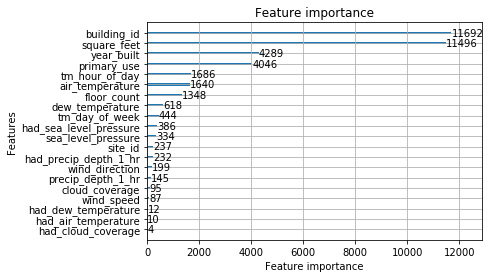

In [17]:
#输出预测结果
result = np.zeros(len(X))
for val in X['meter'].unique():
    ix = np.nonzero((X['meter'] == val).to_numpy())
    for i in tqdm(range(n_splits)):
        #加载刚才保存的模型
        #model = lgb.Booster(model_file='lgb_val{}_fold{}.bin'.format(val, i))
        model = joblib.load('lgb_val{}_fold{}.bin'.format(val, i))
        plt.figure(figsize=(12,6))
        lgb.plot_importance(model, max_num_features=30)
        plt.title('lgb_val{} _fold{} feature importance'.format(val, t))
        plt.show()
        result[ix] += model.predict(X.iloc[ix].drop(columns=['meter']), num_iteration=model.best_iteration_)/n_splits
        del model
        gc.collect();
    
predictions = pd.DataFrame({
    "row_id": X.index,
    "meter_reading": np.clip(np.expm1(result), 0, None)
})

# float_format设置保留四位小数，减少文件大小，为文件上传节省时间
predictions.to_csv("submission.csv", index=False, float_format="%.4f")